In [1]:
# importing packages and modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
from analysis_utils import *
from io_utils import *
import dynamic_glmhmm
from scipy.stats import multivariate_normal, norm

sns.set_context("talk")

ibl_data_path = '../data_IBL'
colorsFeatures = [['#FAA61A','indigo','#99CC66','#59C3C3','#9593D9'],['#FAA61A',"#2369BD","#A9373B",'#99CC66','#59C3C3','#9593D9']]
colorsStates = ['darkorange','darkblue','forestgreen','purple']
myFeatures = [['bias','contrast right','contrast left', 'previous choice', 'previous reward'],['bias','signed stimulus', 'previous choice', 'previous reward']]
sns.set_context("talk")
colormap = ['rebeccapurple','teal','darkturquoise','springgreen']

In [2]:
# NO LONGER WORKING, FIND NEW WAY TO DONWLAOD DATA


# # Downloading data, then unzipping manually in folder, then preprocessing with below code, adapted from Psytrack notebook (Roy et al., 2021)

# current_cwd = os.getcwd()
# SPATH = current_cwd 
# ibl_data_path = SPATH + '/../data_IBL'
# os.chdir(ibl_data_path)
# print(os.getcwd())

# !pip install ibllib
# # !wget -nc -O "{SPATH}ibl-behavior-data-Dec2019.zip" "https://ndownloader.figshare.com/files/21623715"
# # !unzip -d "{SPATH}" -n "{SPATH}ibl-behavior-data-Dec2019.zip"

# from ibllib import ONE


# import subprocess

# def runcmd(cmd, verbose = False, *args, **kwargs):

#     process = subprocess.Popen(
#         cmd,
#         stdout = subprocess.PIPE,
#         stderr = subprocess.PIPE,
#         text = True,
#         shell = True
#     )
#     std_out, std_err = process.communicate()
#     if verbose:
#         print(std_out.strip(), std_err)
#     pass

# runcmd('echo "Hello, World!"', verbose = True)

# runcmd("wget https://ndownloader.figshare.com/files/21623715", verbose = True)

# # Search all sessions that have these dataset types.
# required_vars = ['_ibl_trials.choice', '_ibl_trials.contrastLeft',
#                  '_ibl_trials.contrastRight','_ibl_trials.feedbackType']
# one = ONE()
# eids = one.search(required_vars)

# mouseData = pd.DataFrame()
# for eid in eids:
#     lab, _, subject, date, session = eid.split("/")    
#     sess_vars = {
#         "eid": eid,
#         "lab": lab,
#         "subject": subject,
#         "date": date,
#         "session": session,
#     }
#     mouseData = mouseData.append(sess_vars, sort=True, ignore_index=True)

# all_vars = ["contrastLeft", "contrastRight", "choice", "feedbackType", "probabilityLeft"]
# df = pd.DataFrame()

# all_mice = []
# for j, s in enumerate(mouseData["subject"].unique()):
#     print("\rProcessing " + str(j+1) + " of " + str(len(mouseData["subject"].unique())), end="")
#     mouse = mouseData[mouseData["subject"]==s].sort_values(['date', 'session']).reset_index()
#     for i, row in mouse.iterrows():
#         myVars = {}
#         for v in all_vars:
#             filename = "_ibl_trials." + v + ".npy"
#             var_file = os.path.join(ibl_data_path, row.eid, "alf", filename)
#             myVars[v] = list(np.load(var_file).flatten())

#         num_trials = len(myVars[v])
#         myVars['lab'] = [row.lab]*num_trials
#         myVars['subject'] = [row.subject]*num_trials
#         myVars['date'] = [row.date]*num_trials
#         myVars['session'] = [row.session]*num_trials

#         all_mice += [pd.DataFrame(myVars, columns=myVars.keys())]
        
# df = pd.concat(all_mice, ignore_index=True)

# df = df[df['choice'] != 0]        # dump mistrials
# df = df[df['feedbackType'] != 0]  # 3 anomalous trials from ZM_1084, omit
# df.loc[np.isnan(df['contrastLeft']), "contrastLeft"] = 0
# df.loc[np.isnan(df['contrastRight']), "contrastRight"] = 0
# df.loc[df["contrastRight"] < 0, "contrastLeft"] = np.abs(df.loc[df["contrastRight"] < 0, "contrastRight"])
# df.loc[df["contrastRight"] < 0, "contrastRight"] = 0  # 81 anomalous trials in CSHL_002, correct
# df["correctSide"] = df["feedbackType"] * df["choice"]      # new column to indicate correct answer
# df.loc[df["correctSide"]==1, "correctSide"] = 0
# df.loc[df["correctSide"]==-1, "correctSide"] = 1
# df.loc[df["feedbackType"]==-1, "feedbackType"] = 0
# df.loc[df["choice"]==1, "choice"] = 0
# df.loc[df["choice"]==-1, "choice"] = 1
# df.to_csv(SPATH+"ibl_processed.csv", index=False)

In [3]:
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')
dfAll.head()

,contrastLeft,contrastRight,choice,feedbackType,probabilityLeft,lab,subject,date,session,correctSide
0,1.0,0.0,1,0,1.0,angelakilab,IBL-T1,2019-02-09,1,0
1,1.0,0.0,1,0,1.0,angelakilab,IBL-T1,2019-02-09,1,0
2,0.0,1.0,1,1,1.0,angelakilab,IBL-T1,2019-02-09,1,1
3,0.5,0.0,0,1,0.5,angelakilab,IBL-T1,2019-02-09,1,0
4,0.5,0.0,0,1,0.9,angelakilab,IBL-T1,2019-02-09,1,0


In [4]:
# only looking at animals from 3 labs (32 total animals)
labChosen =  ['angelakilab','churchlandlab','wittenlab']
subjectsAll = []
for lab in labChosen:
    subjects = np.unique(dfAll[dfAll['lab'] == lab]['subject']).tolist()
    subjectsAll = subjectsAll + subjects

# removing missing or incomplete animals
if ('NYU-01' in subjectsAll):
    subjectsAll.remove('NYU-01')
if ('NYU-06' in subjectsAll):
    subjectsAll.remove('NYU-06')
if ('CSHL_007' in subjectsAll):
    subjectsAll.remove('CSHL_007')
if ('CSHL049' in subjectsAll):
    subjectsAll.remove('CSHL049')

In [5]:
x, y, sessInd, correctSide = get_mouse_design(dfAll, subject='ibl_witten_15', sessStop=None, signedStimulus=False, pTanh=5)

subjectsWitten = np.unique(dfAll[dfAll['lab'] == 'wittenlab']['subject'])
print(subjectsWitten)

['ibl_witten_02' 'ibl_witten_03' 'ibl_witten_04' 'ibl_witten_05'
 'ibl_witten_06' 'ibl_witten_07' 'ibl_witten_12' 'ibl_witten_13'
 'ibl_witten_14' 'ibl_witten_15' 'ibl_witten_16']


In [39]:
# concatanating post-training data across half the mice into one global dataset
firstSubject = 'ibl_witten_02'
signedStimulus = True
pTanh = None
x, y, sessInd, correctSide = get_mouse_design(dfAll, subject=firstSubject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh) 
for subject in subjectsAll:
    if (subject != firstSubject):
        xTemp, yTemp, sessIndTemp, correctSideTemp = get_mouse_design(dfAll, subject=subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh) 

        # using all data
        x = np.concatenate((x,xTemp))
        y = np.concatenate((y,yTemp))
        sessInd = sessInd + [i + sessInd[-1] for i in sessIndTemp[1:]]

print(x.shape)
print(y.shape)
# np.save(f'../data_IBL/X_allAnimals_pTanh={pTanh}_signedStimulus={signedStimulus}', x)
# np.save(f'../data_IBL/Y_allAnimals_pTanh={pTanh}_signedStimulus={signedStimulus}', y)
# np.save(f'../data_IBL/sessInd_allAnimals_pTanh={pTanh}_signedStimulus={signedStimulus}', sessInd)

# print(subjectsWitten)
x = np.load(f'../data_IBL/X_allAnimals_pTanh={pTanh}_signedStimulus={signedStimulus}.npy')
y = np.load(f'../data_IBL/Y_allAnimals_pTanh={pTanh}_signedStimulus={signedStimulus}.npy')
sessInd = np.load(f'../data_IBL/sessInd_allAnimals_pTanh={pTanh}_signedStimulus={signedStimulus}.npy')

(1755215, 4)
(1755215,)


In [14]:
print(np.unique(x[;]))

[ 0. -1.  1. ... -1.  1.  1.]


In [40]:
np.unique(x[:,1])

array([-2.08601571, -2.01832607, -2.00175363, -1.99240539, -1.9784245 ,
       -1.96600162, -1.96118162, -1.9574752 , -1.94932012, -1.94281475,
       -1.93298682, -1.92402075, -1.91356904, -1.91027564, -1.88854344,
       -1.88725976, -1.87953058, -1.8698816 , -1.86310399, -1.84737532,
       -1.84588695, -1.84472457, -1.82925168, -1.81730144, -1.7954962 ,
       -1.77916413, -1.7405802 , -1.5548138 , -1.52832012, -1.47234829,
       -1.43278779, -1.40563612, -1.04300786, -1.00916304, -1.00087681,
       -0.9962027 , -0.98921225, -0.98300081, -0.98059081, -0.9787376 ,
       -0.97466006, -0.97140738, -0.96649341, -0.96201037, -0.95678452,
       -0.95513782, -0.94427172, -0.94362988, -0.93976529, -0.9349408 ,
       -0.93155199, -0.92368766, -0.92294347, -0.92236228, -0.91462584,
       -0.90865072, -0.8977481 , -0.88958206, -0.8702901 , -0.7774069 ,
       -0.76416006, -0.73617414, -0.71639389, -0.70281806, -0.52150393,
       -0.50458152, -0.50043841, -0.49810135, -0.49460613, -0.49

In [9]:
np.tanh ( 0.01 * np.unique(x[:,1])) / np.tanh(0.01)

array([0.        , 0.06250208, 0.1250041 , 0.25000781, 0.5000125 ,
       1.        ])

(1, 5, 2)
(2, 5, 2)
(3, 5, 2)
(4, 5, 2)


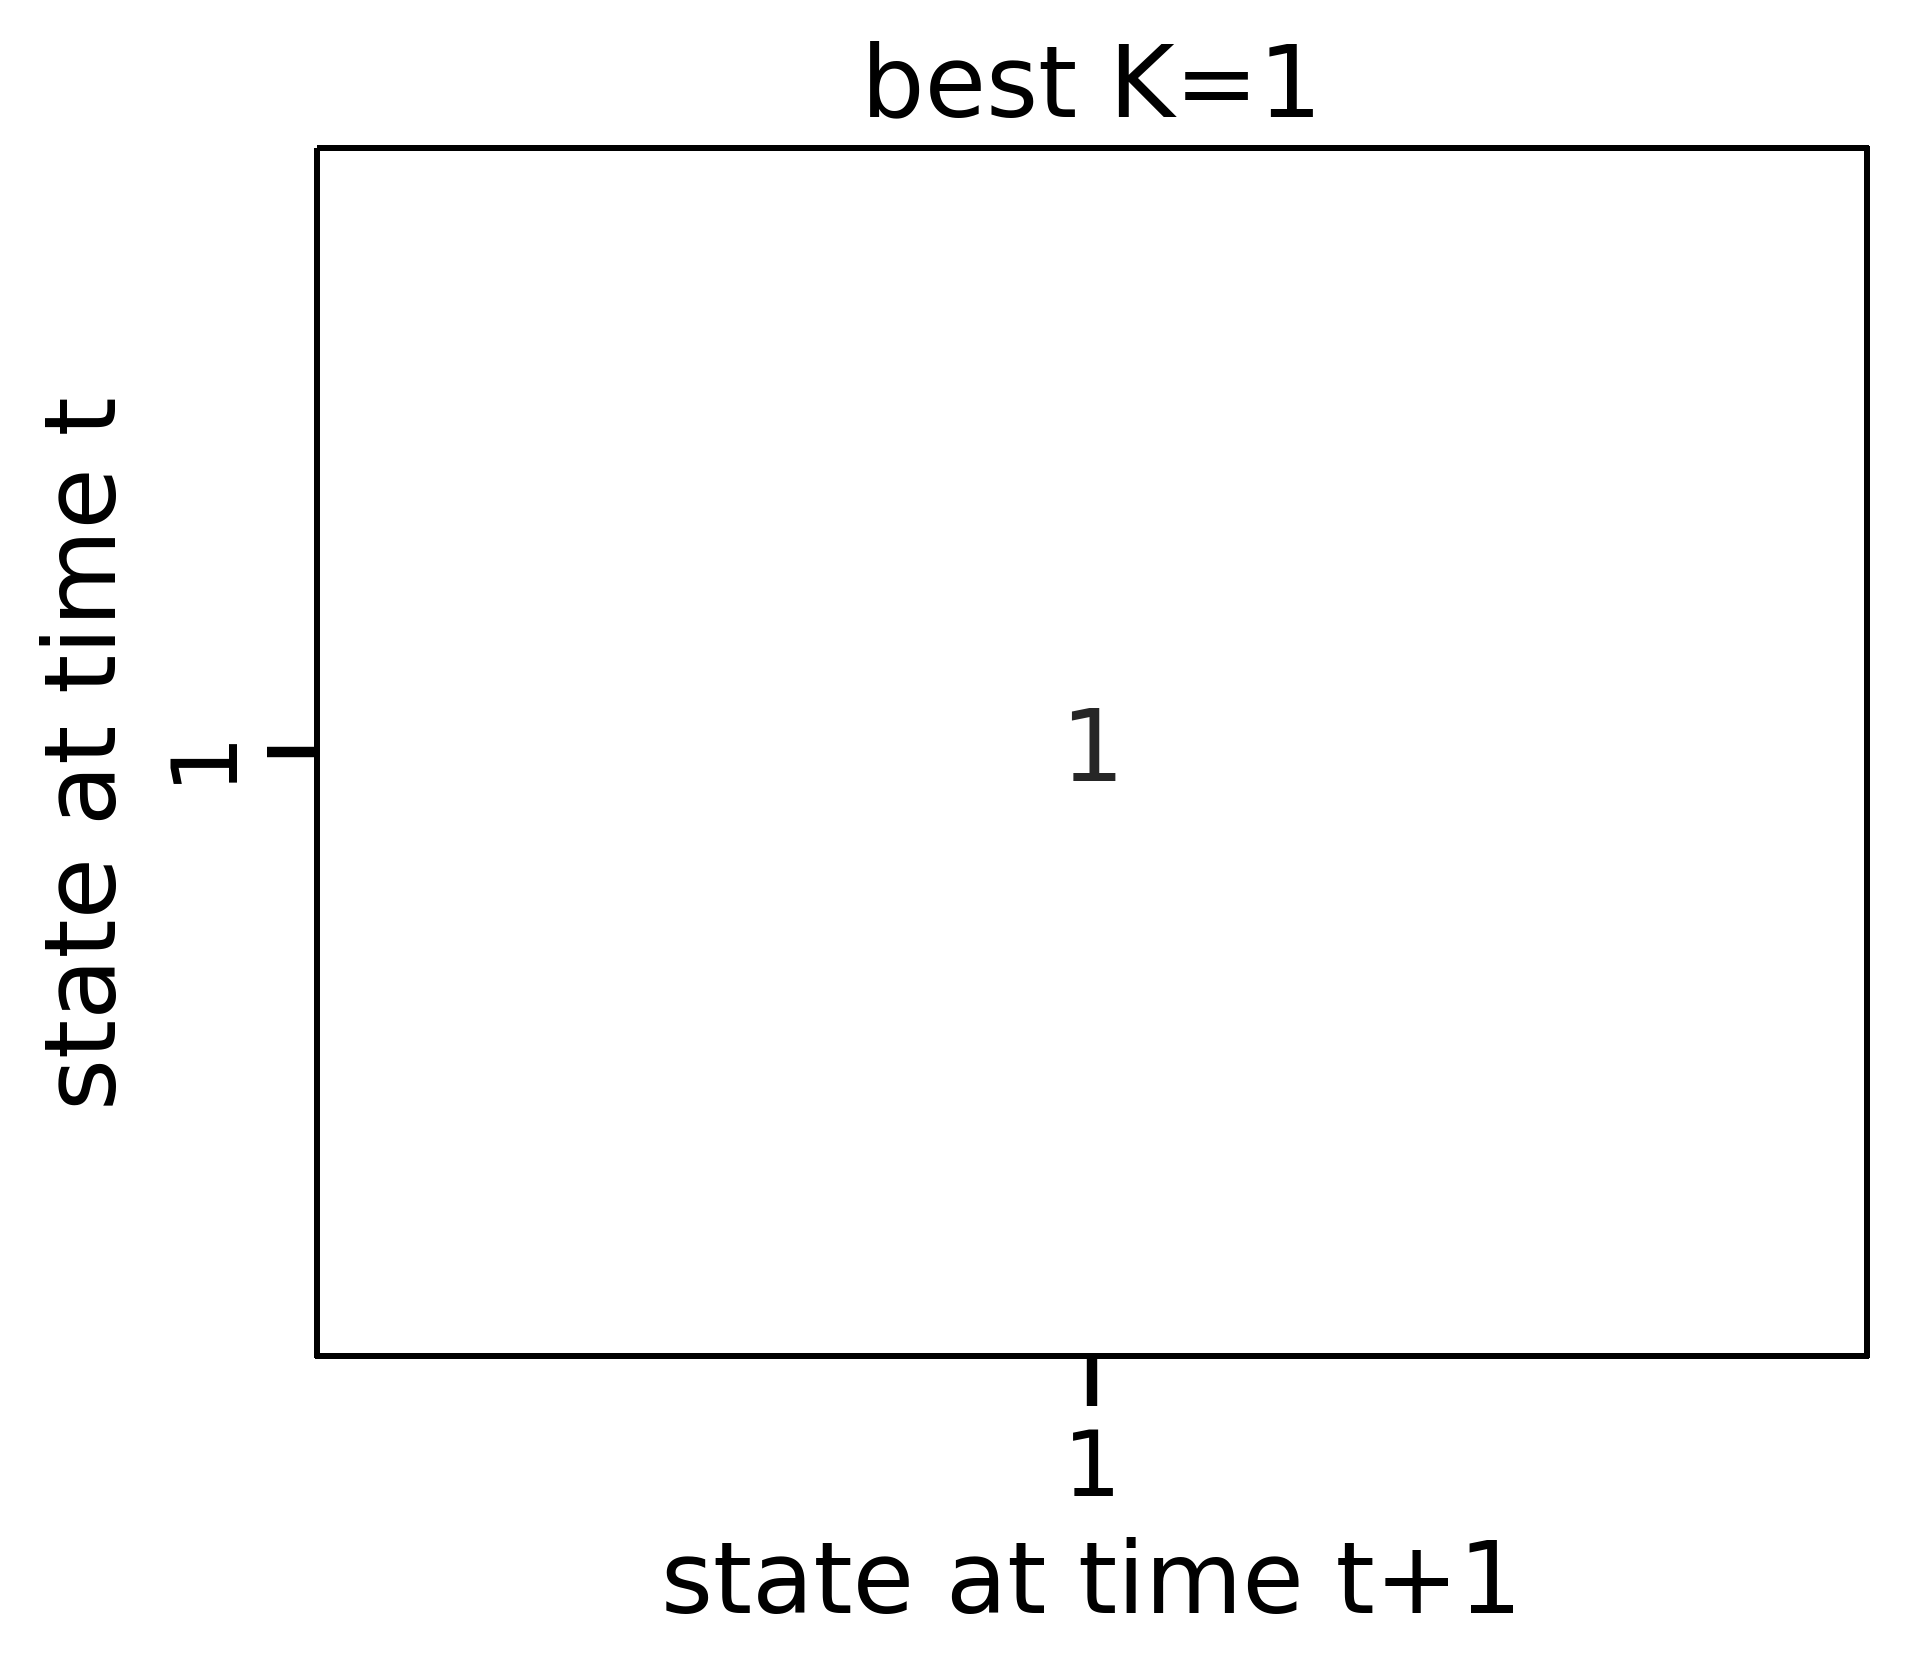

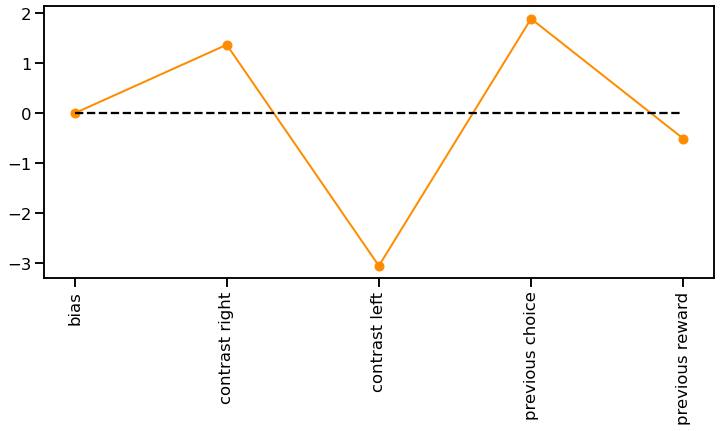

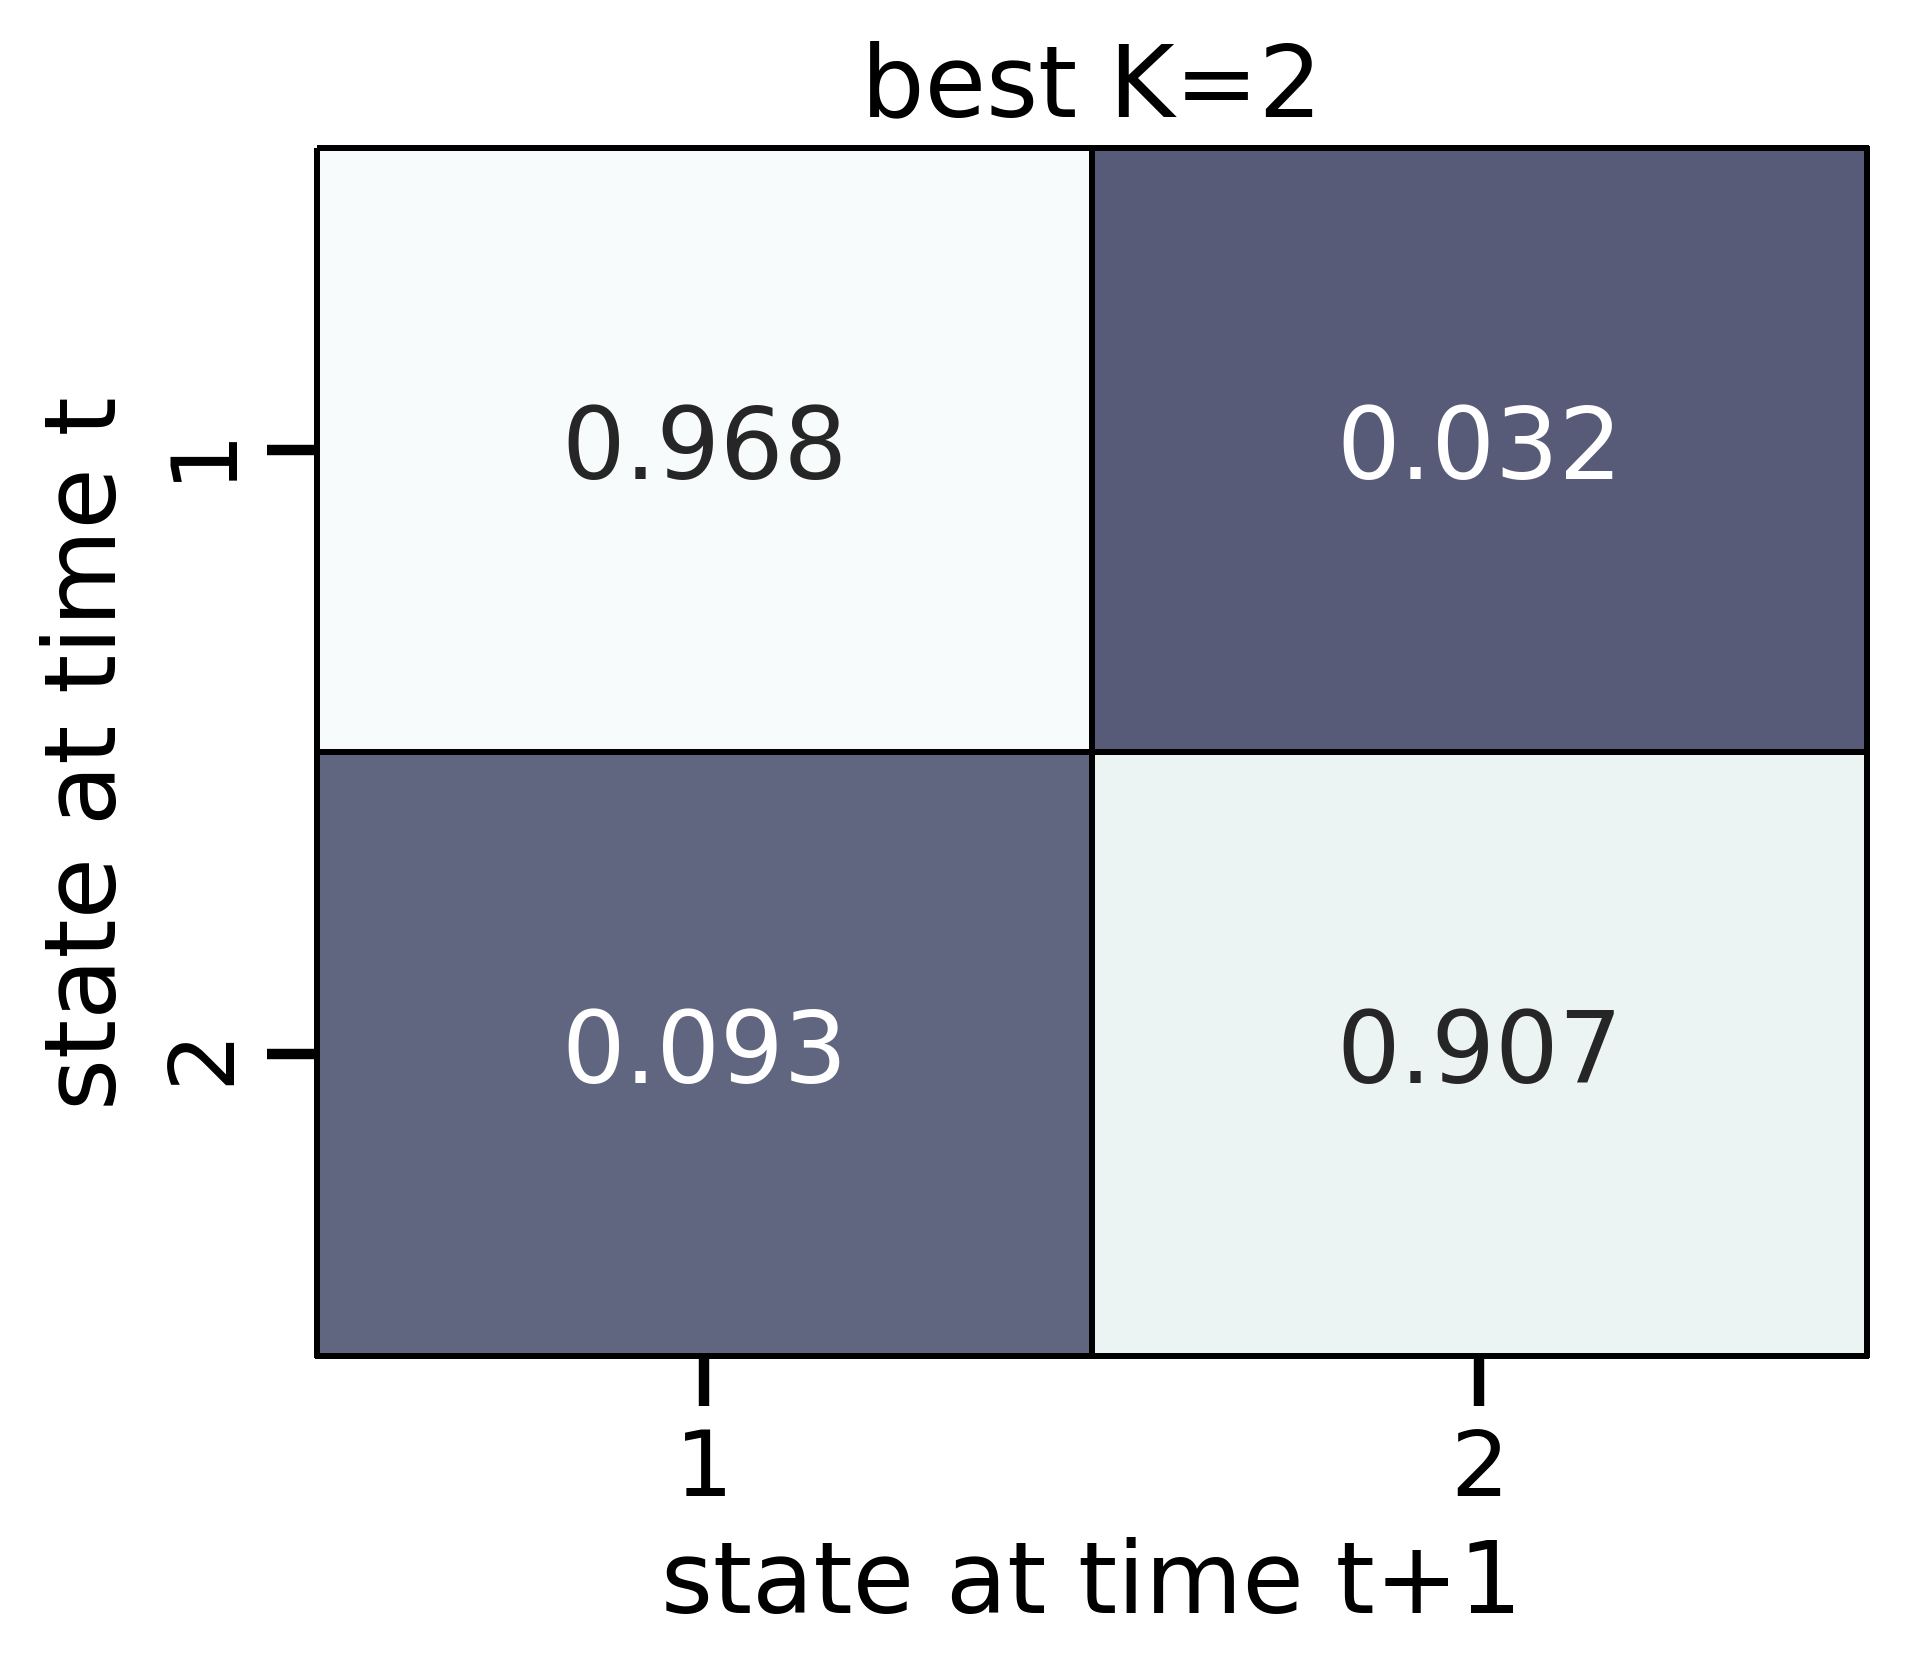

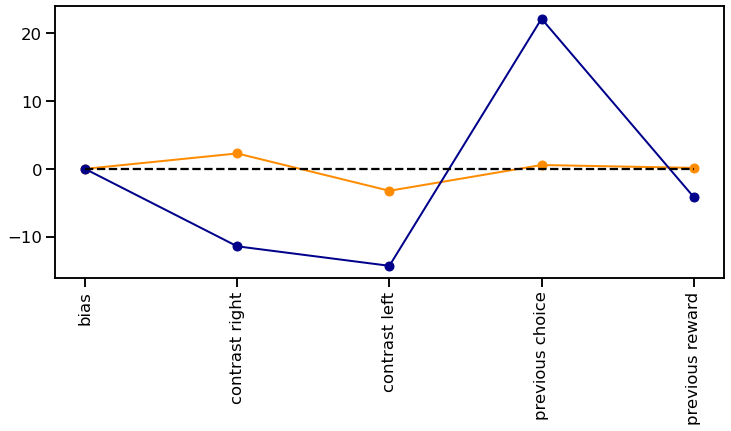

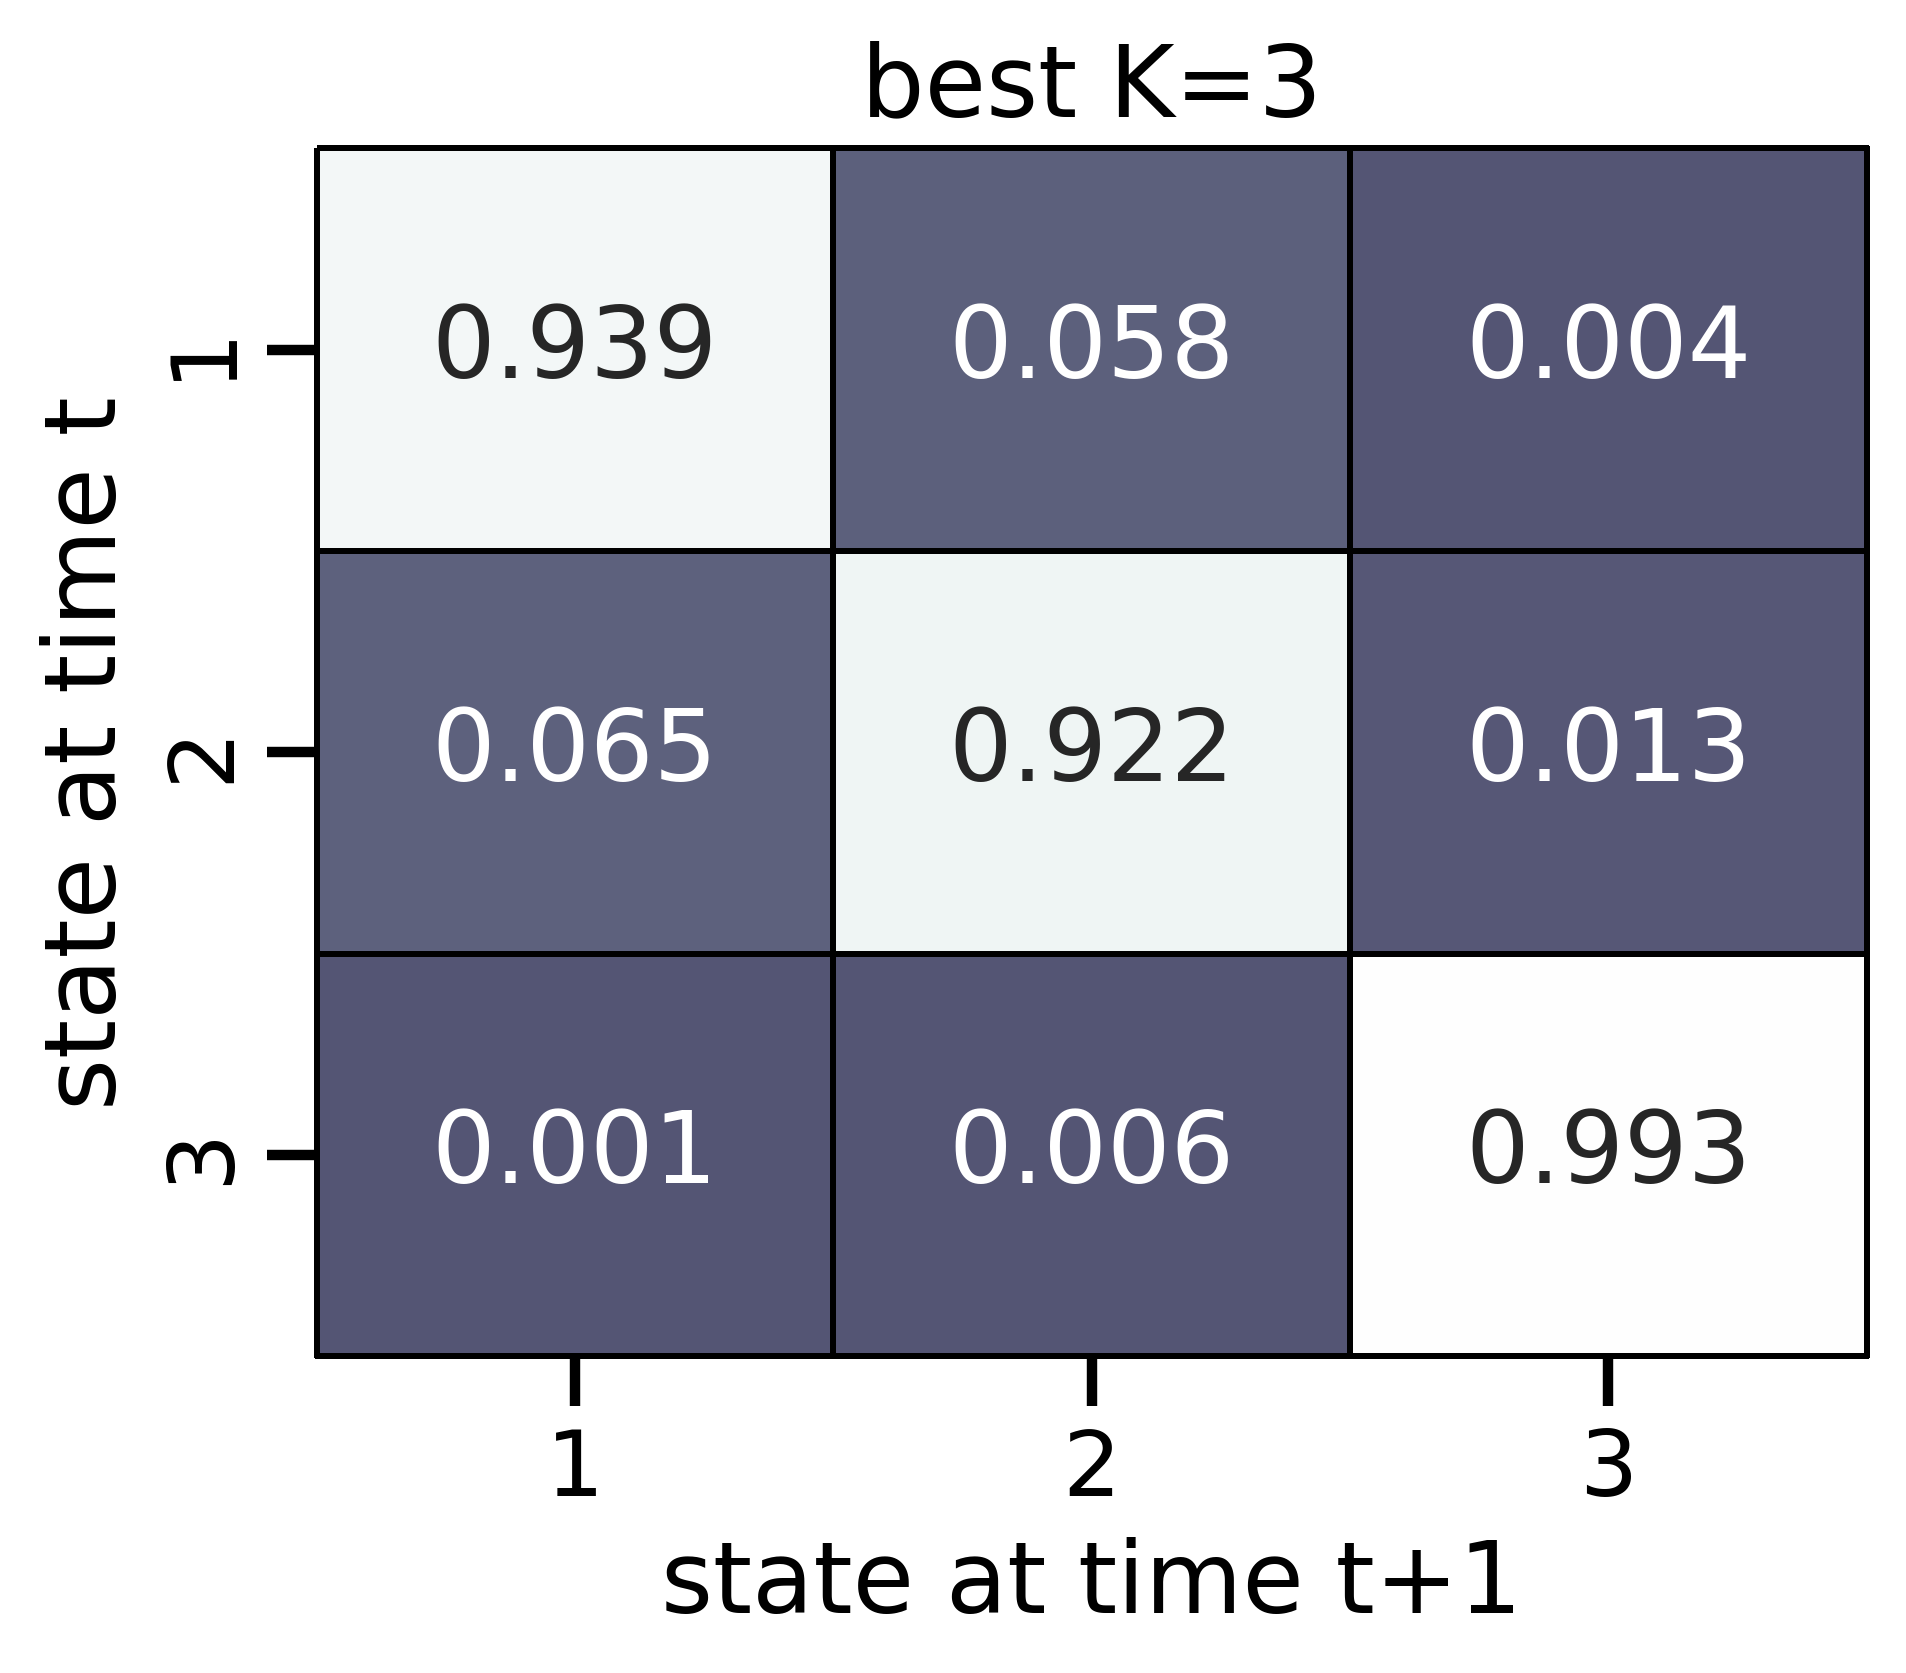

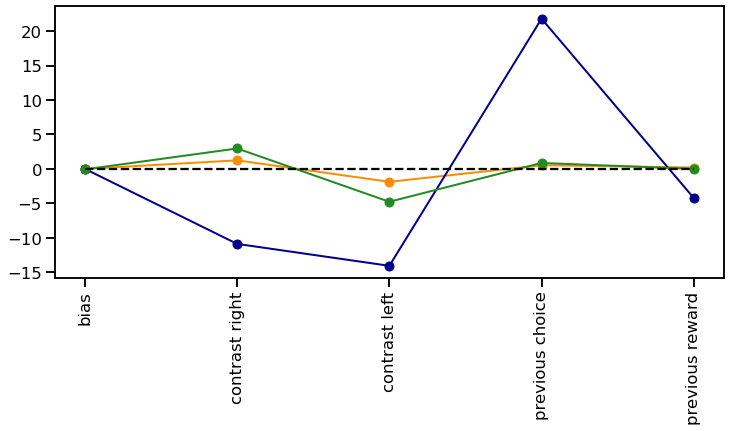

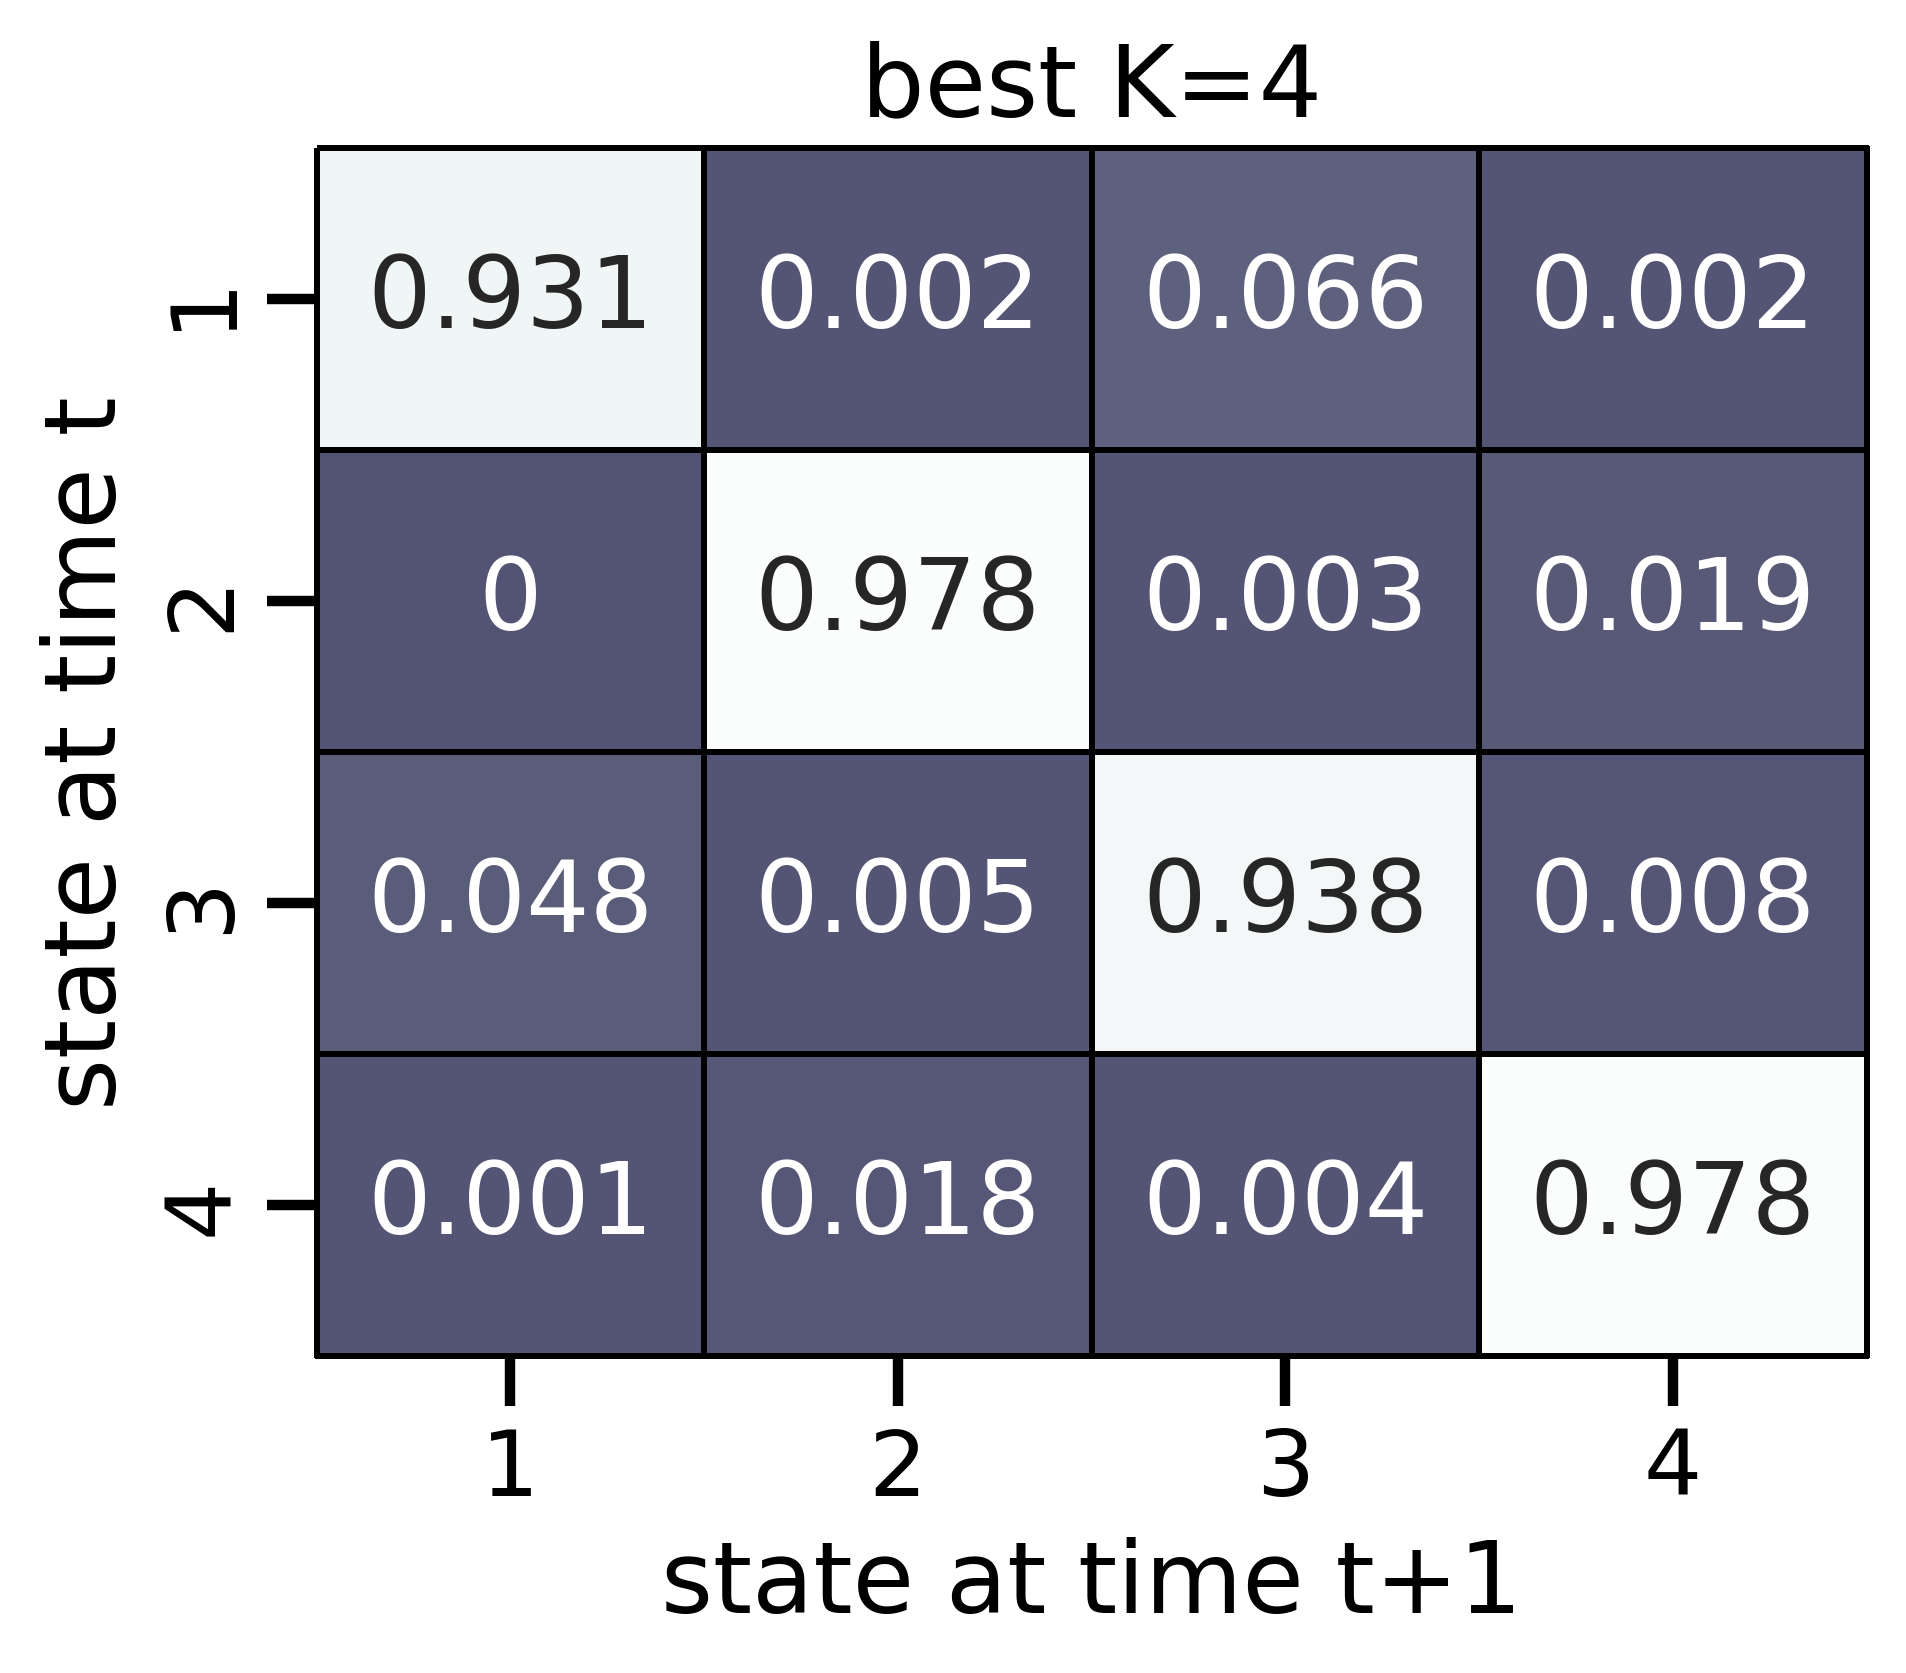

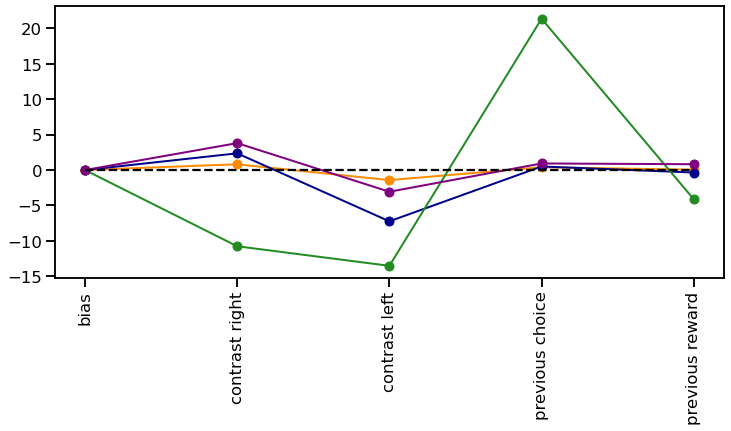

In [8]:
signedStimulus = False
# pTanh=5 (although I forgot to write in file name)
D = 4
C = 2
inits = 20
ll_vs_K = []
for K in [1,2,3,4]:#,2,3]:#,4,5]:
    df = pd.DataFrame(columns=['trainLl', 'trainAccuracy' ,'P', 'pi', 'W']) 
    for init in range(0,inits):
        data = np.load(f'../data_IBL/allAnimals_standardGLMHMM_{K}-state_init={init}_signedStimulus={signedStimulus}.npz')
        df.loc[init, 'P'] = data['P']
        df.loc[init, 'pi'] = data['pi']
        df.loc[init, 'W'] = data['W']
        df.loc[init, 'trainLl'] = data['trainLl']

    # print(ll)
    ll = np.array(df['trainLl']).flatten()
    bestInd = np.argmax(ll)

    ll_vs_K.append(ll[bestInd])

    print(df.loc[bestInd, 'W'][0].shape)
    # reorder parameters if necessary

    # plot parameters
    plot_transition_matrix(df.loc[bestInd, 'P'][0], title=f'best K={K}')
    fig, axes = plt.subplots(1, figsize=(12,5))
    plot_constant_weights(df.loc[bestInd, 'W'][0], axes, labels=myFeatures[signedStimulus], colors=colorsStates)
    # axes.set_ylim(-10,10)


    # # saving best models
    # np.savez(f'../data_IBL/Best_standardGLMHMM_halfAnimals_signedStimulus={signedStimulus}_{K}-state', P=df.loc[bestInd, 'P'], pi=df.loc[bestInd, 'pi'], W=df.loc[bestInd, 'W'])
    

In [ ]:
np.tanh( 5 & [])

(1, 4, 2)
(2, 4, 2)
(3, 4, 2)


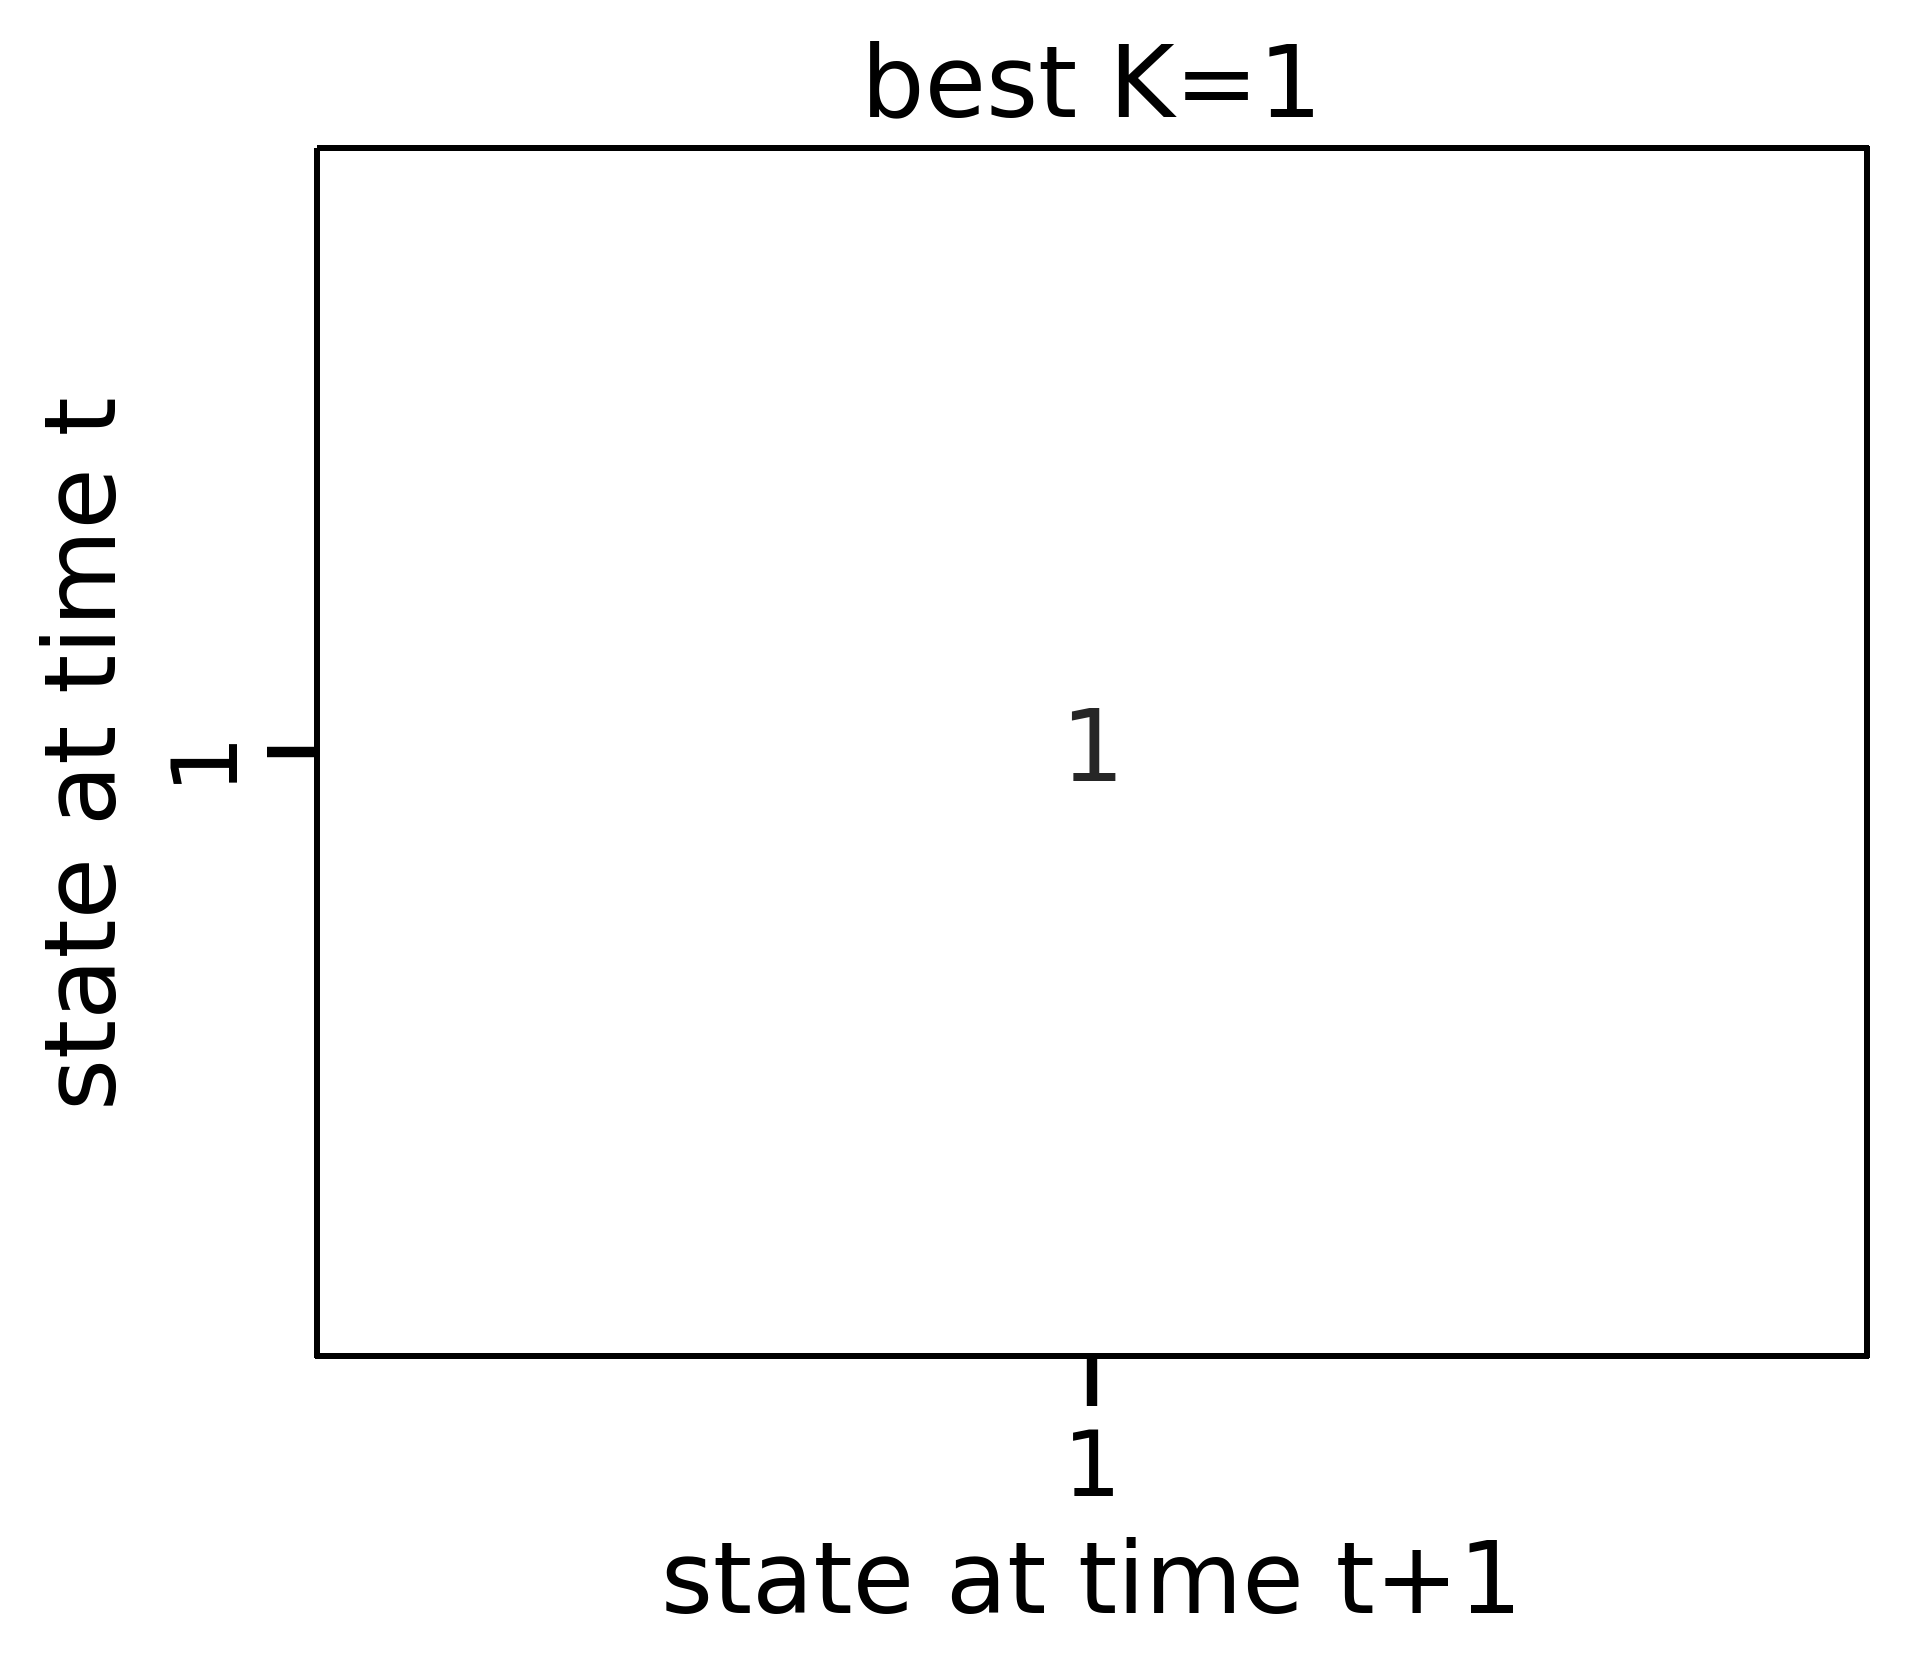

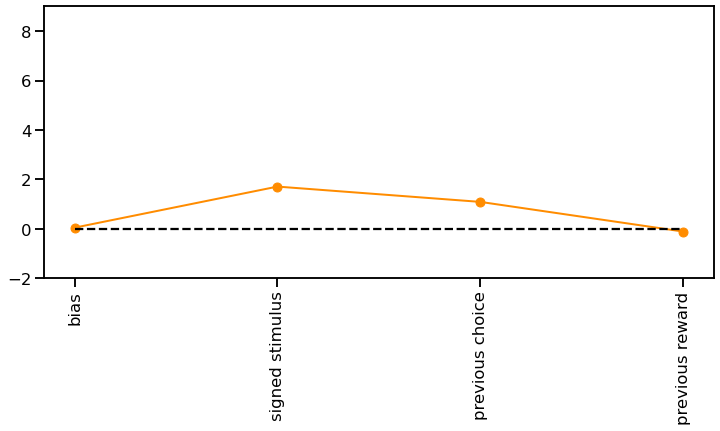

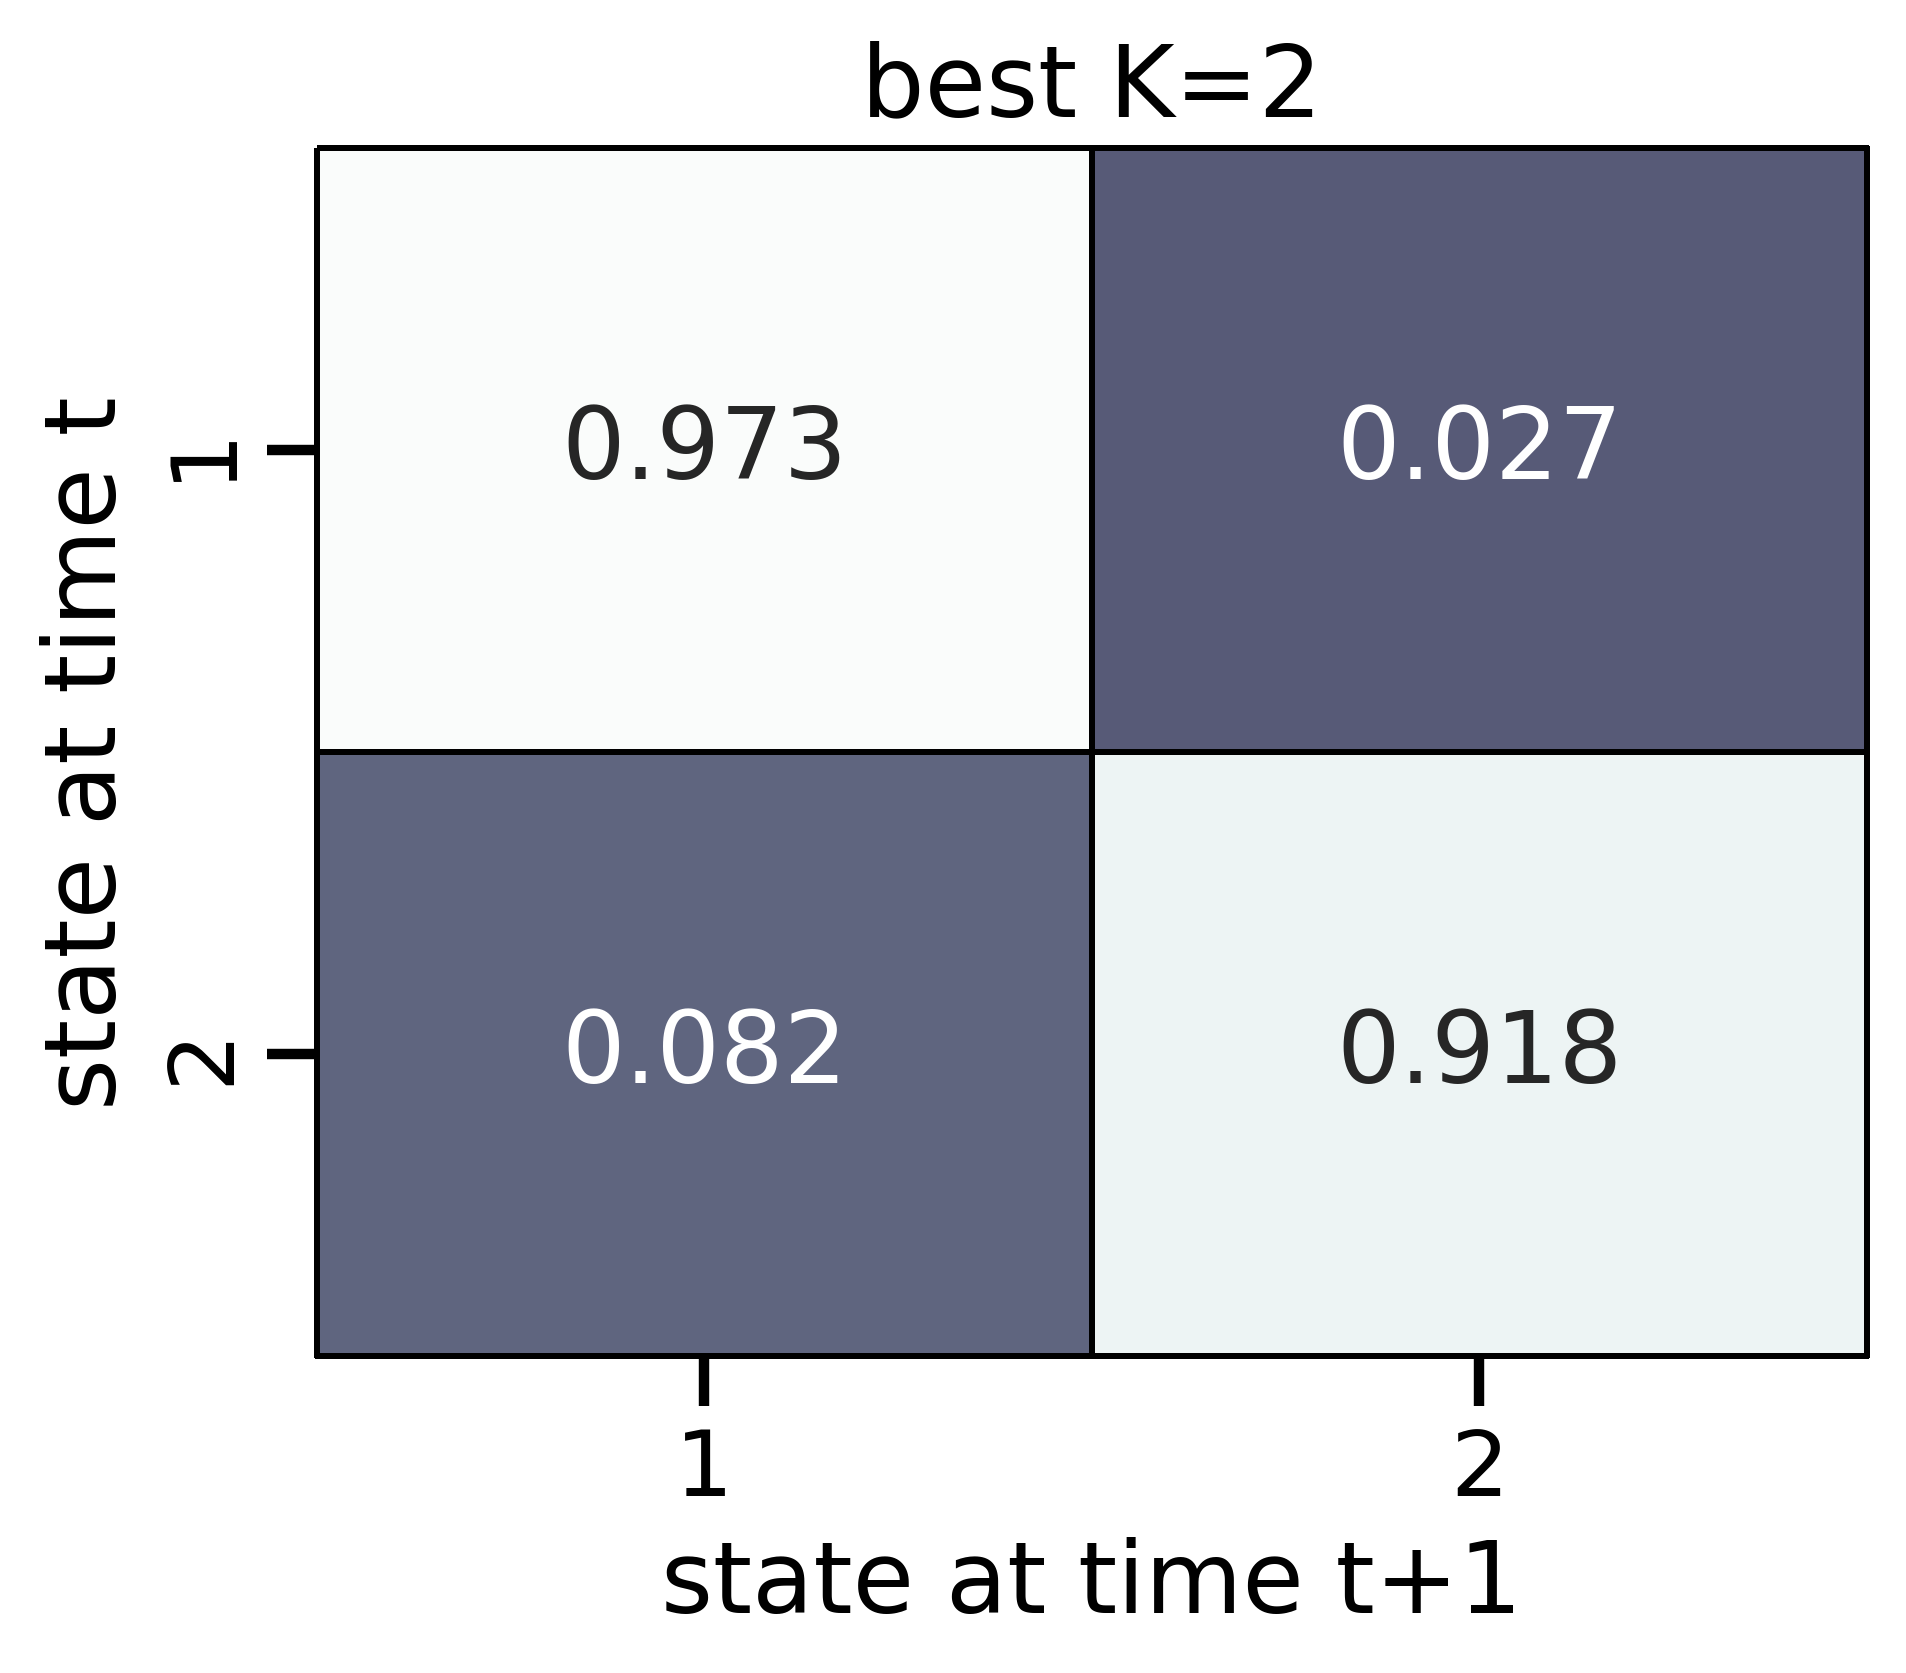

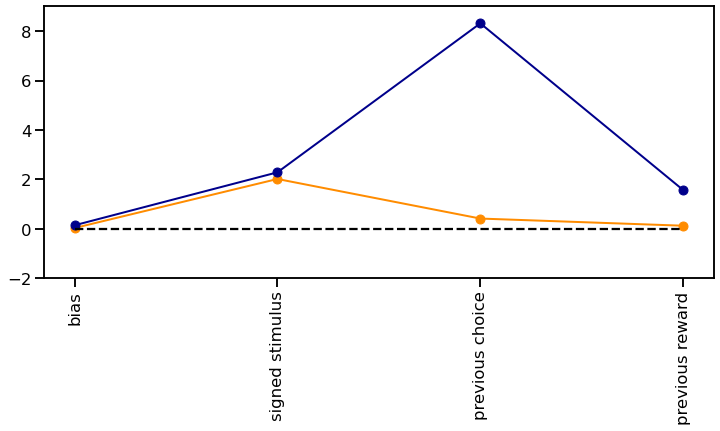

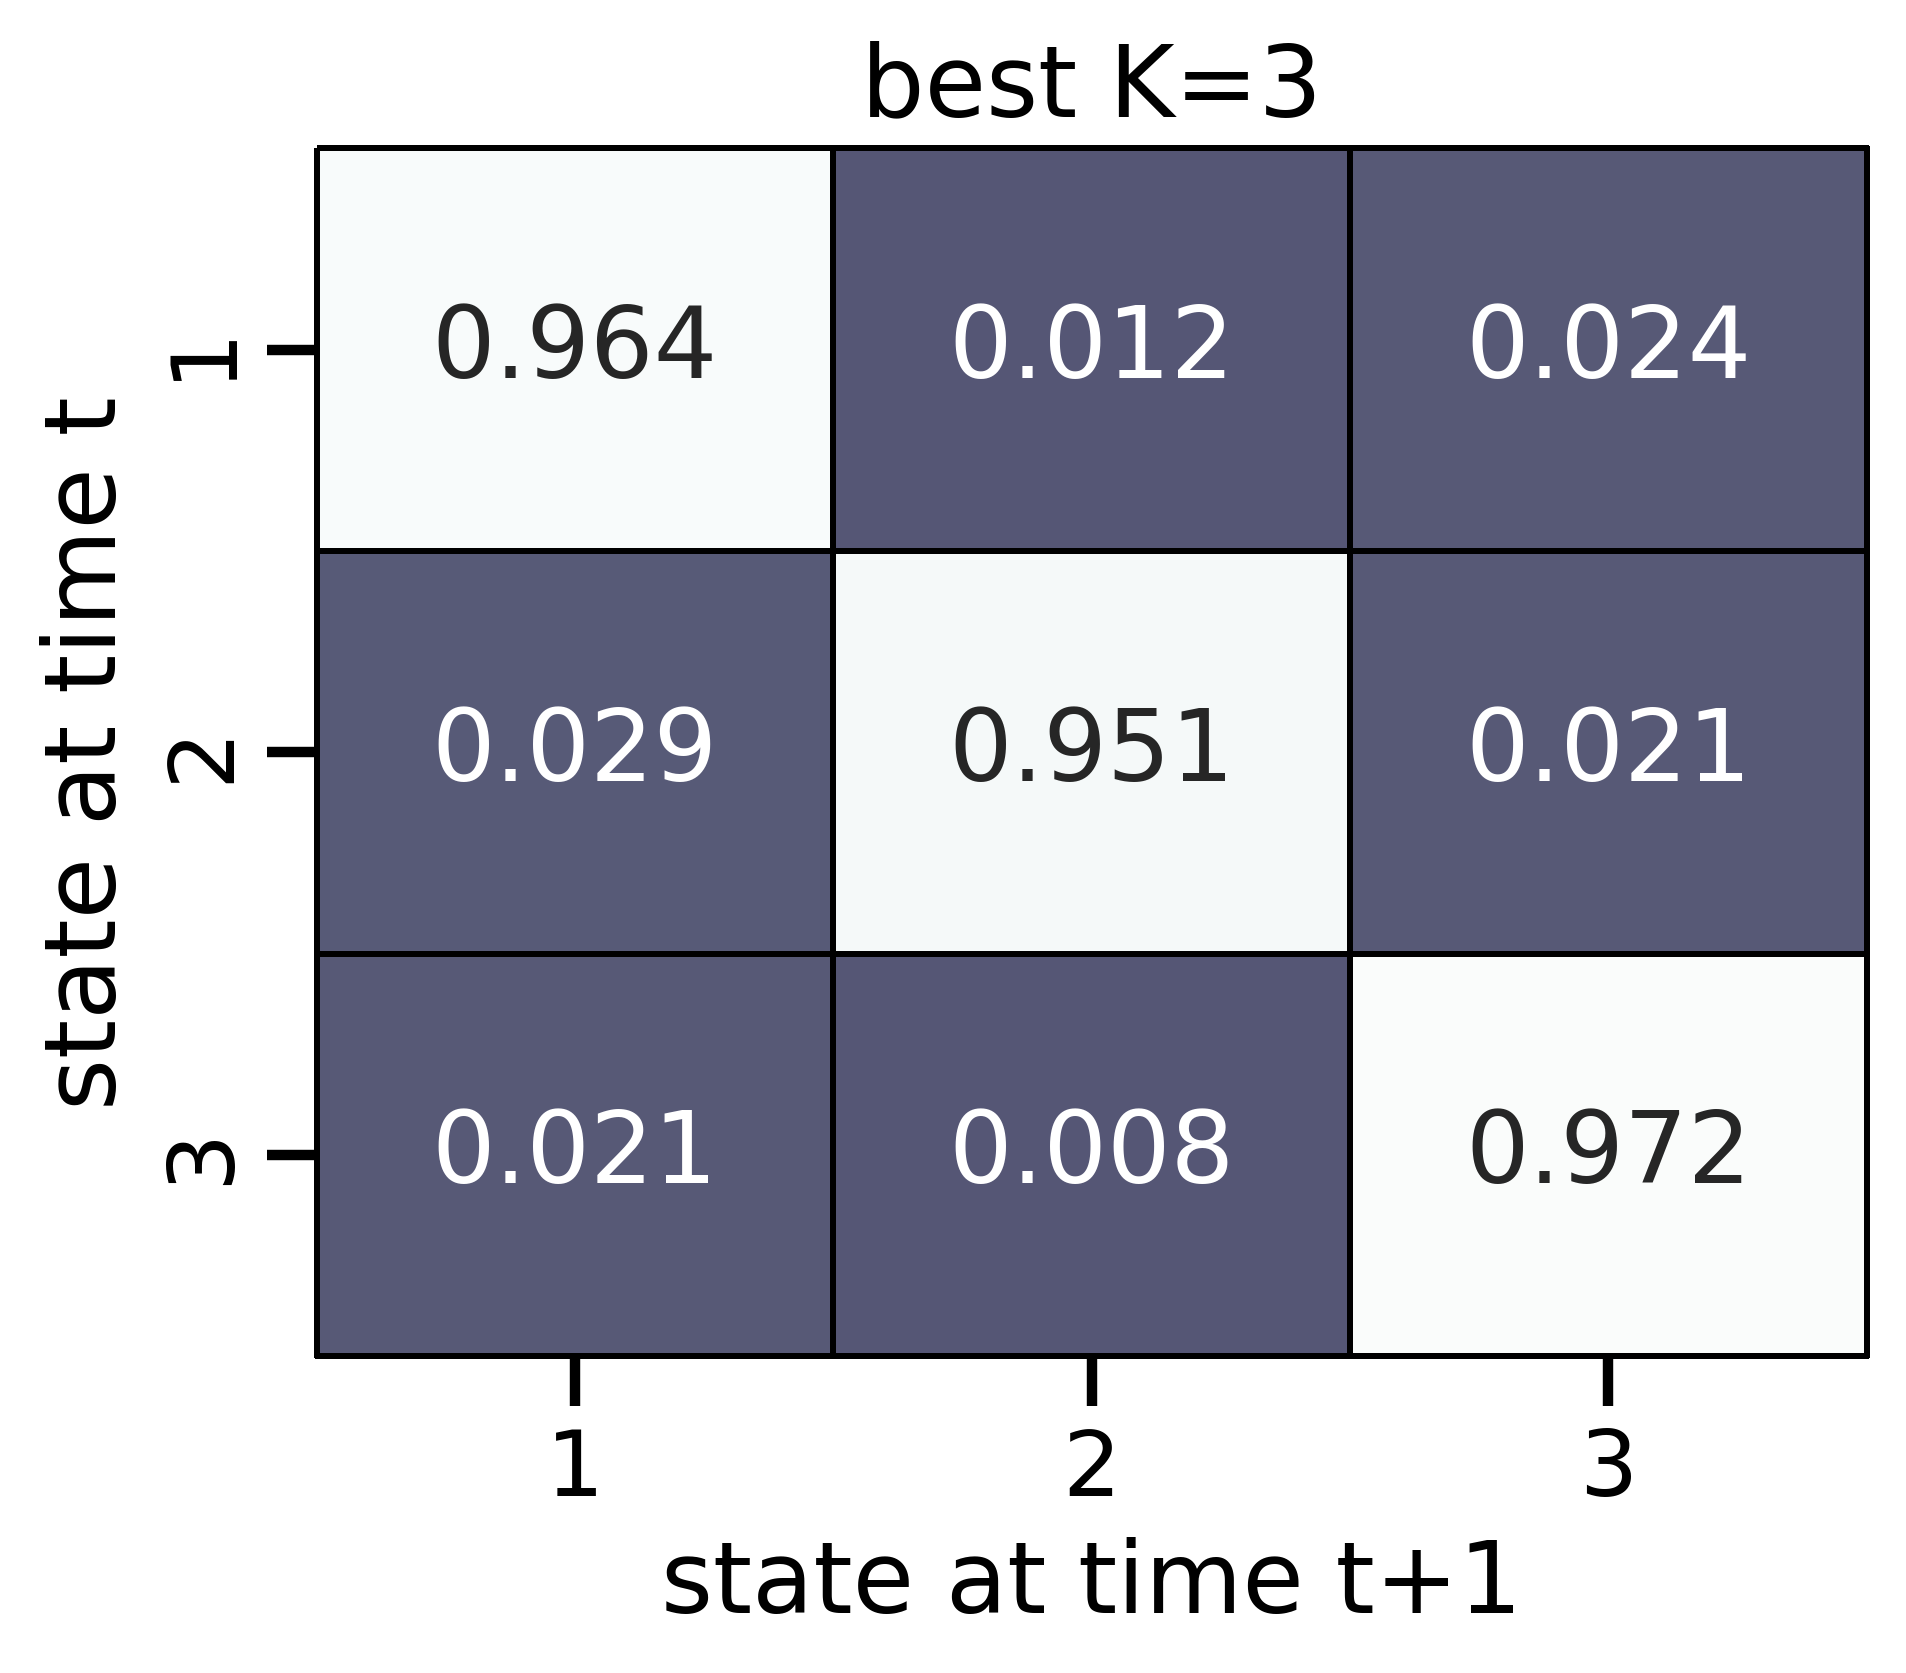

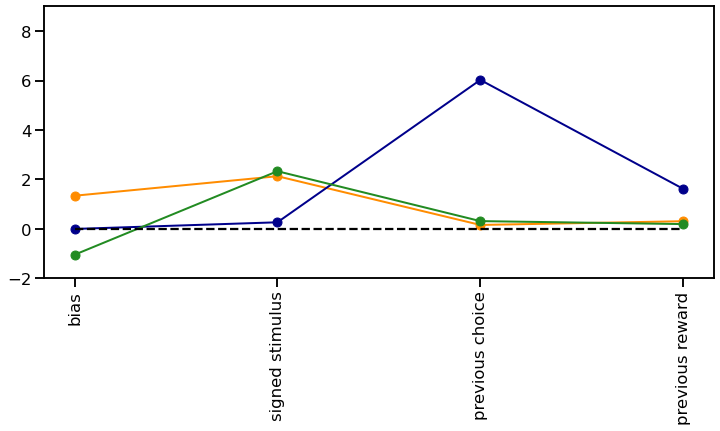

In [35]:
signedStimulus = True
D = 4
C = 2
inits = 20
ll_vs_K = []
for K in [1,2,3]:#,2,3]:#,4,5]:
    df = pd.DataFrame(columns=['trainLl', 'trainAccuracy' ,'P', 'pi', 'W']) 
    for init in range(0,inits):
        data = np.load(f'../data_IBL/allAnimals_standardGLMHMM_{K}-state_init={init}_signedStimulus={signedStimulus}.npz')
        df.loc[init, 'P'] = data['P']
        df.loc[init, 'pi'] = data['pi']
        df.loc[init, 'W'] = data['W']
        df.loc[init, 'trainLl'] = data['trainLl']

    # print(ll)
    ll = np.array(df['trainLl']).flatten()
    bestInd = np.argmax(ll)

    ll_vs_K.append(ll[bestInd])

    print(df.loc[bestInd, 'W'][0].shape)
    # reorder parameters if necessary

    # plot parameters
    plot_transition_matrix(df.loc[bestInd, 'P'][0], title=f'best K={K}')
    fig, axes = plt.subplots(1, figsize=(12,5))
    plot_constant_weights(df.loc[bestInd, 'W'][0], axes, labels=myFeatures[signedStimulus], colors=colorsStates)
    axes.set_ylim(-2,9)


    # saving best models
    np.savez(f'../data_IBL/Best_standardGLMHMM_halfAnimals_signedStimulus={signedStimulus}_{K}-state', P=df.loc[bestInd, 'P'], pi=df.loc[bestInd, 'pi'], W=df.loc[bestInd, 'W'])
    


In [ ]:
fig, axes = plt.subplots(1, figsize=(5.5,4.5), dpi=400)
axes.plot([1,2,3,4], ll_vs_K,'-o', color='black',alpha=0.2)
axes.set_xticks([1,2,3,4])
# axes.set_yticks([0,0.01,0.02,0.03],[0,0.01,0.02,0.03])
axes.set_xlabel('# of states')
axes.set_ylabel('train LL (per trial)')
axes.spines[['right', 'top']].set_visible(False)
fig.suptitle('Model performance at    = 1', size=22)
fig.tight_layout()

(1, 5, 2)
(2, 5, 2)
(3, 5, 2)
(4, 5, 2)


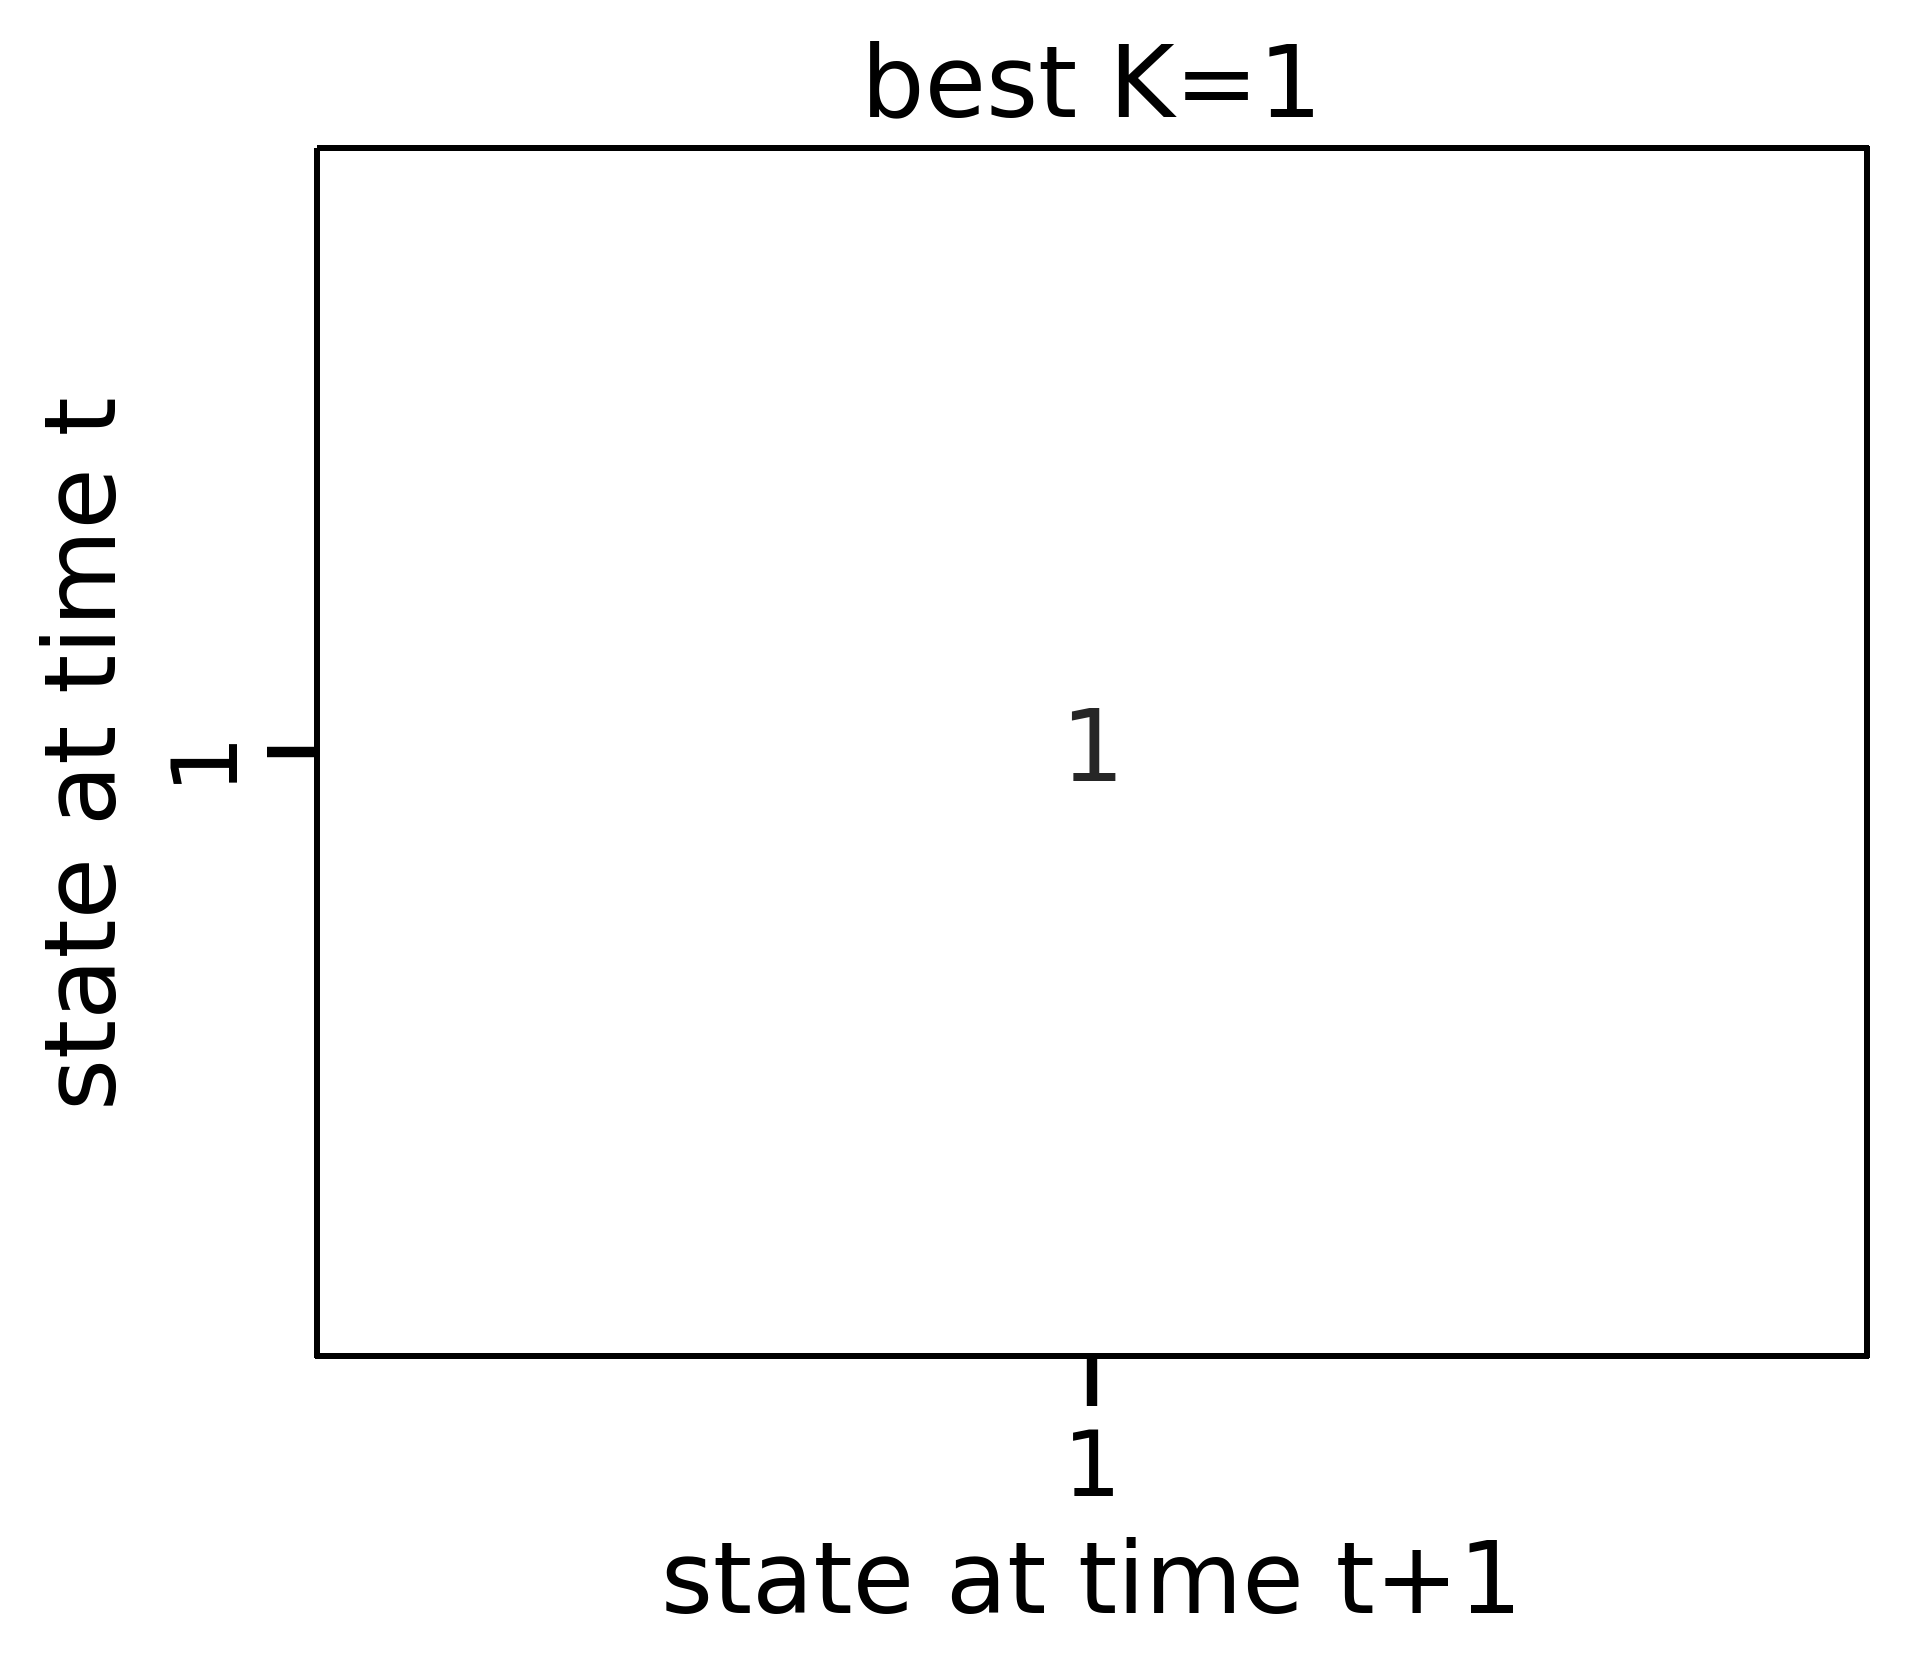

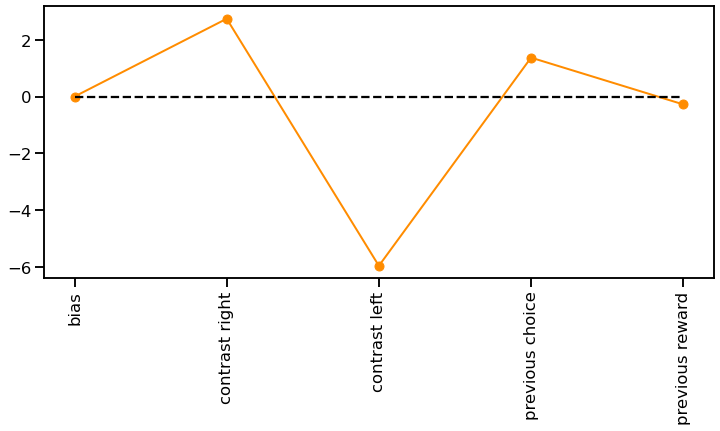

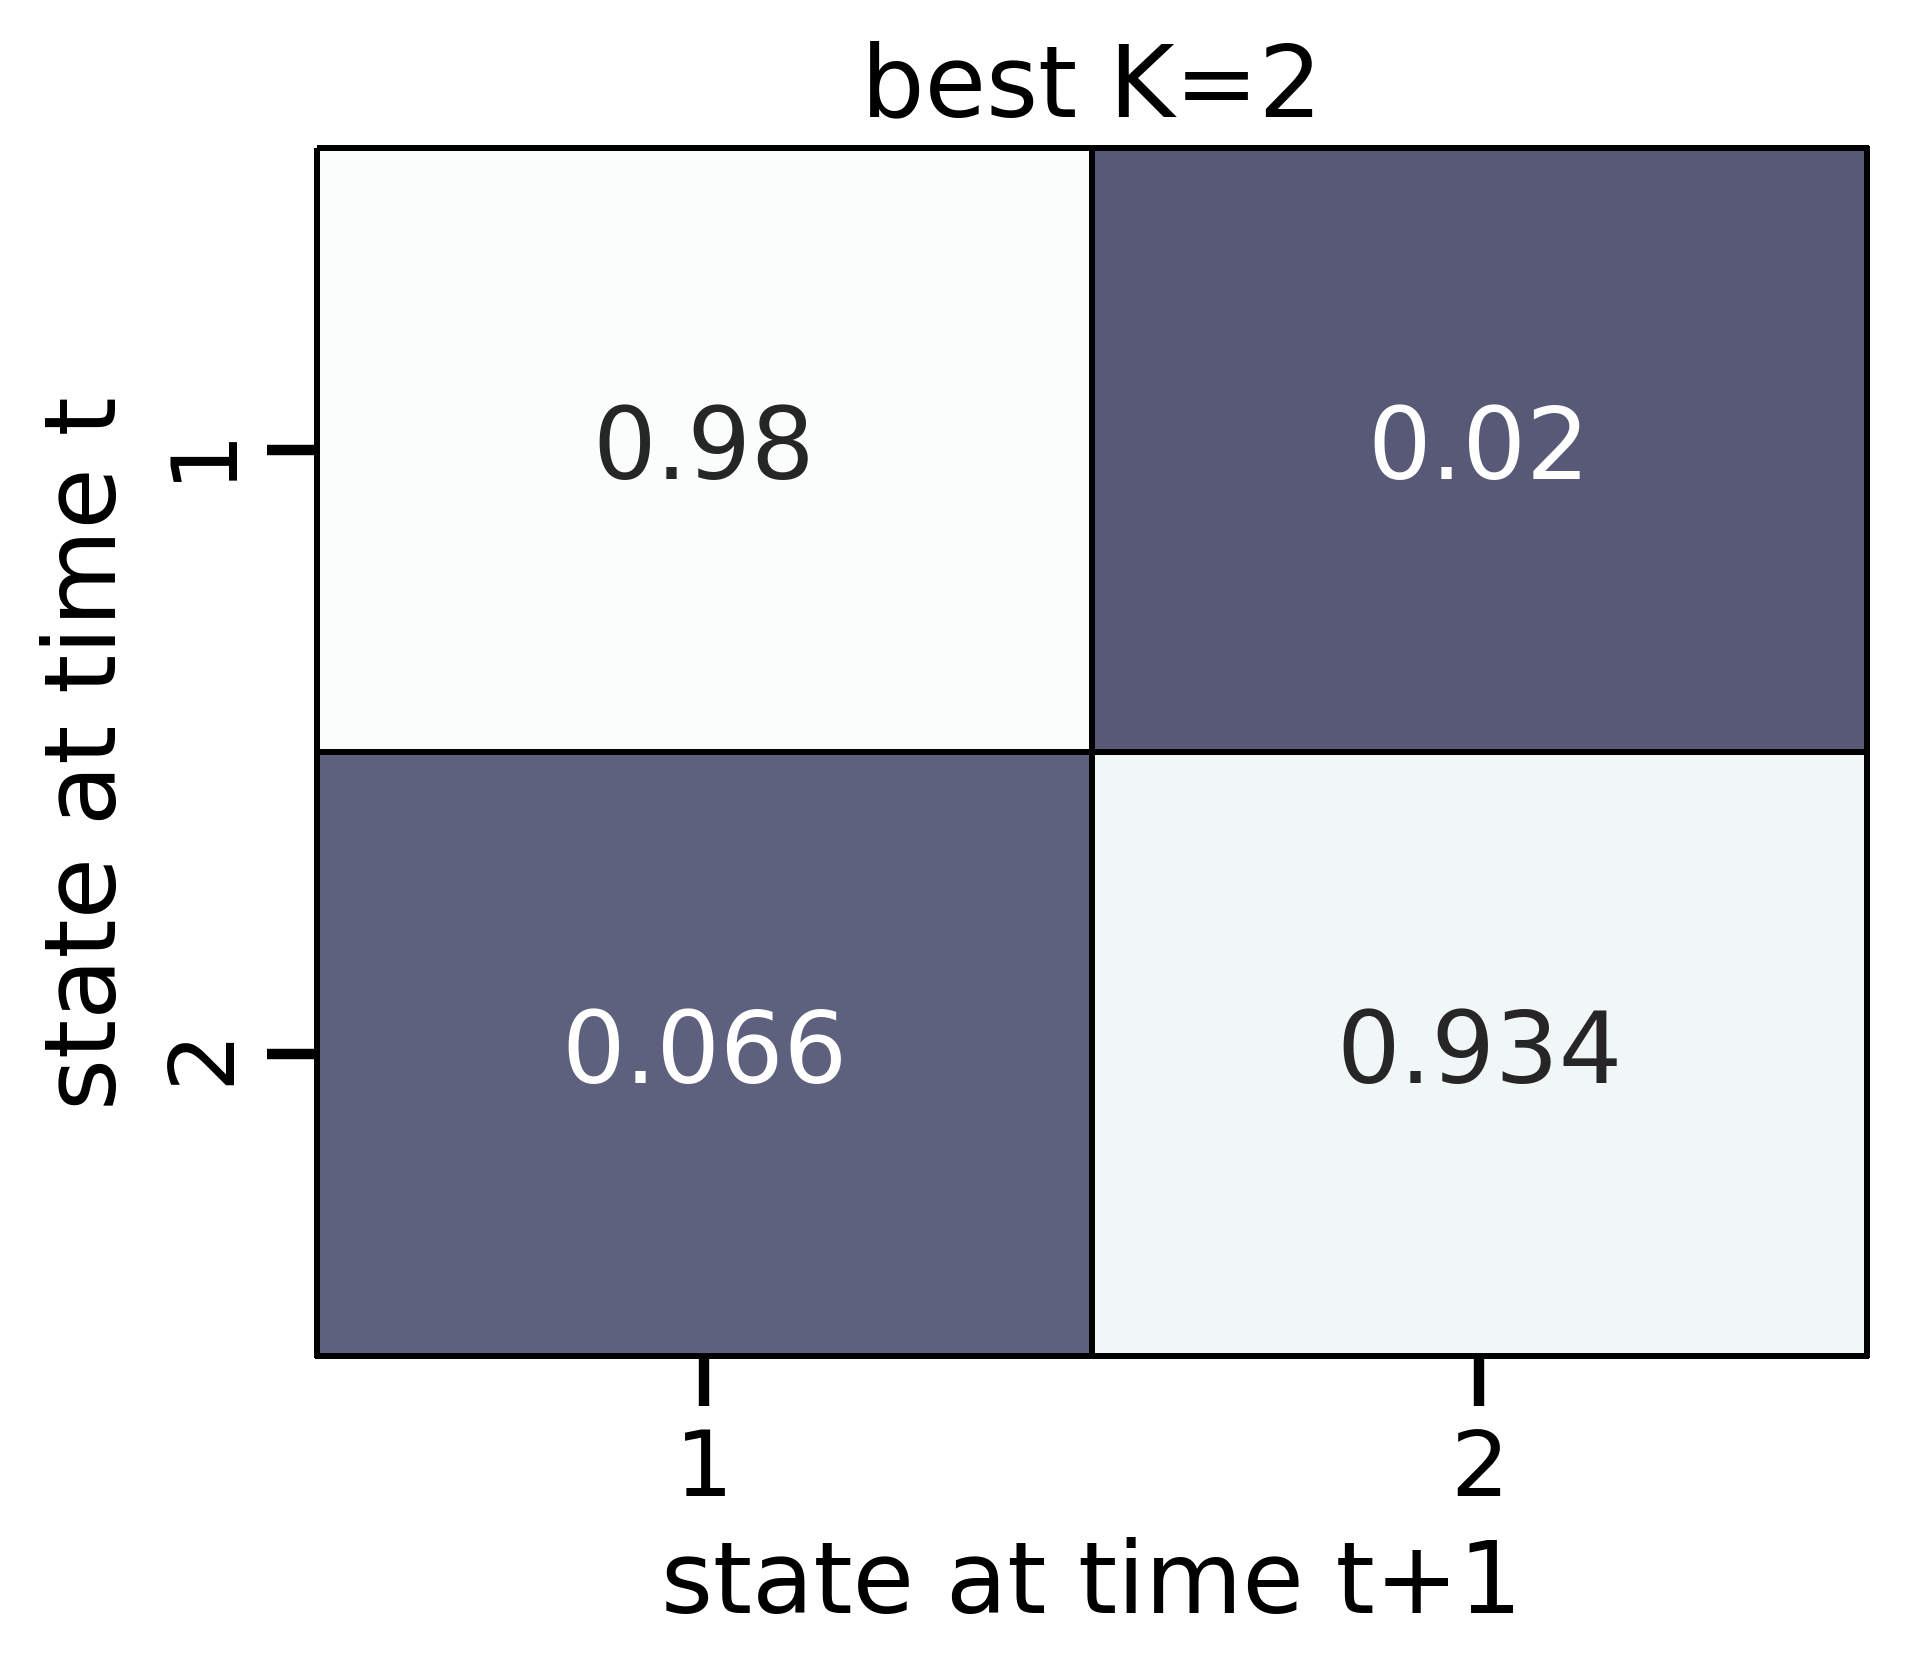

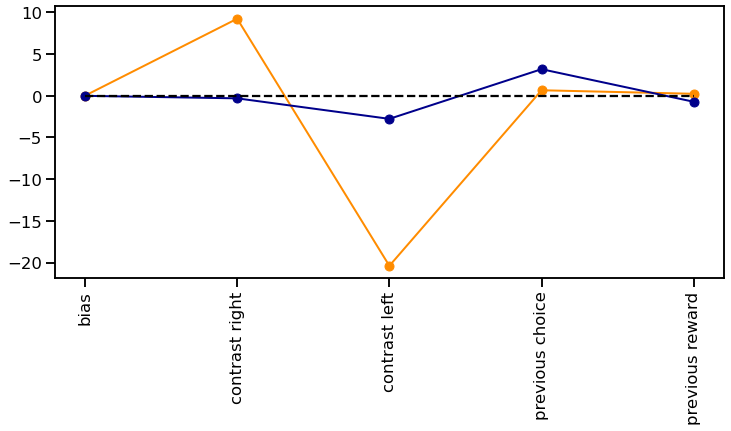

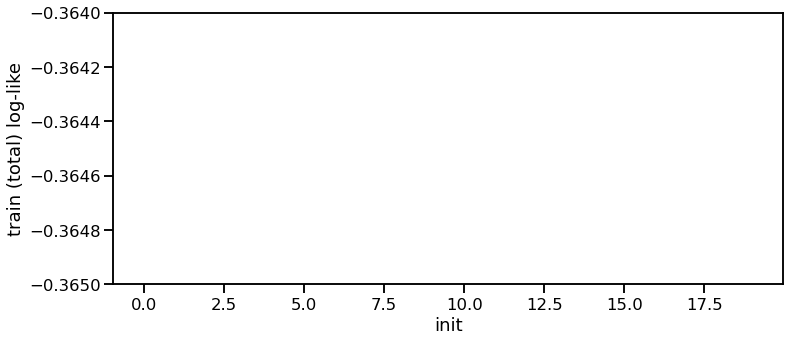

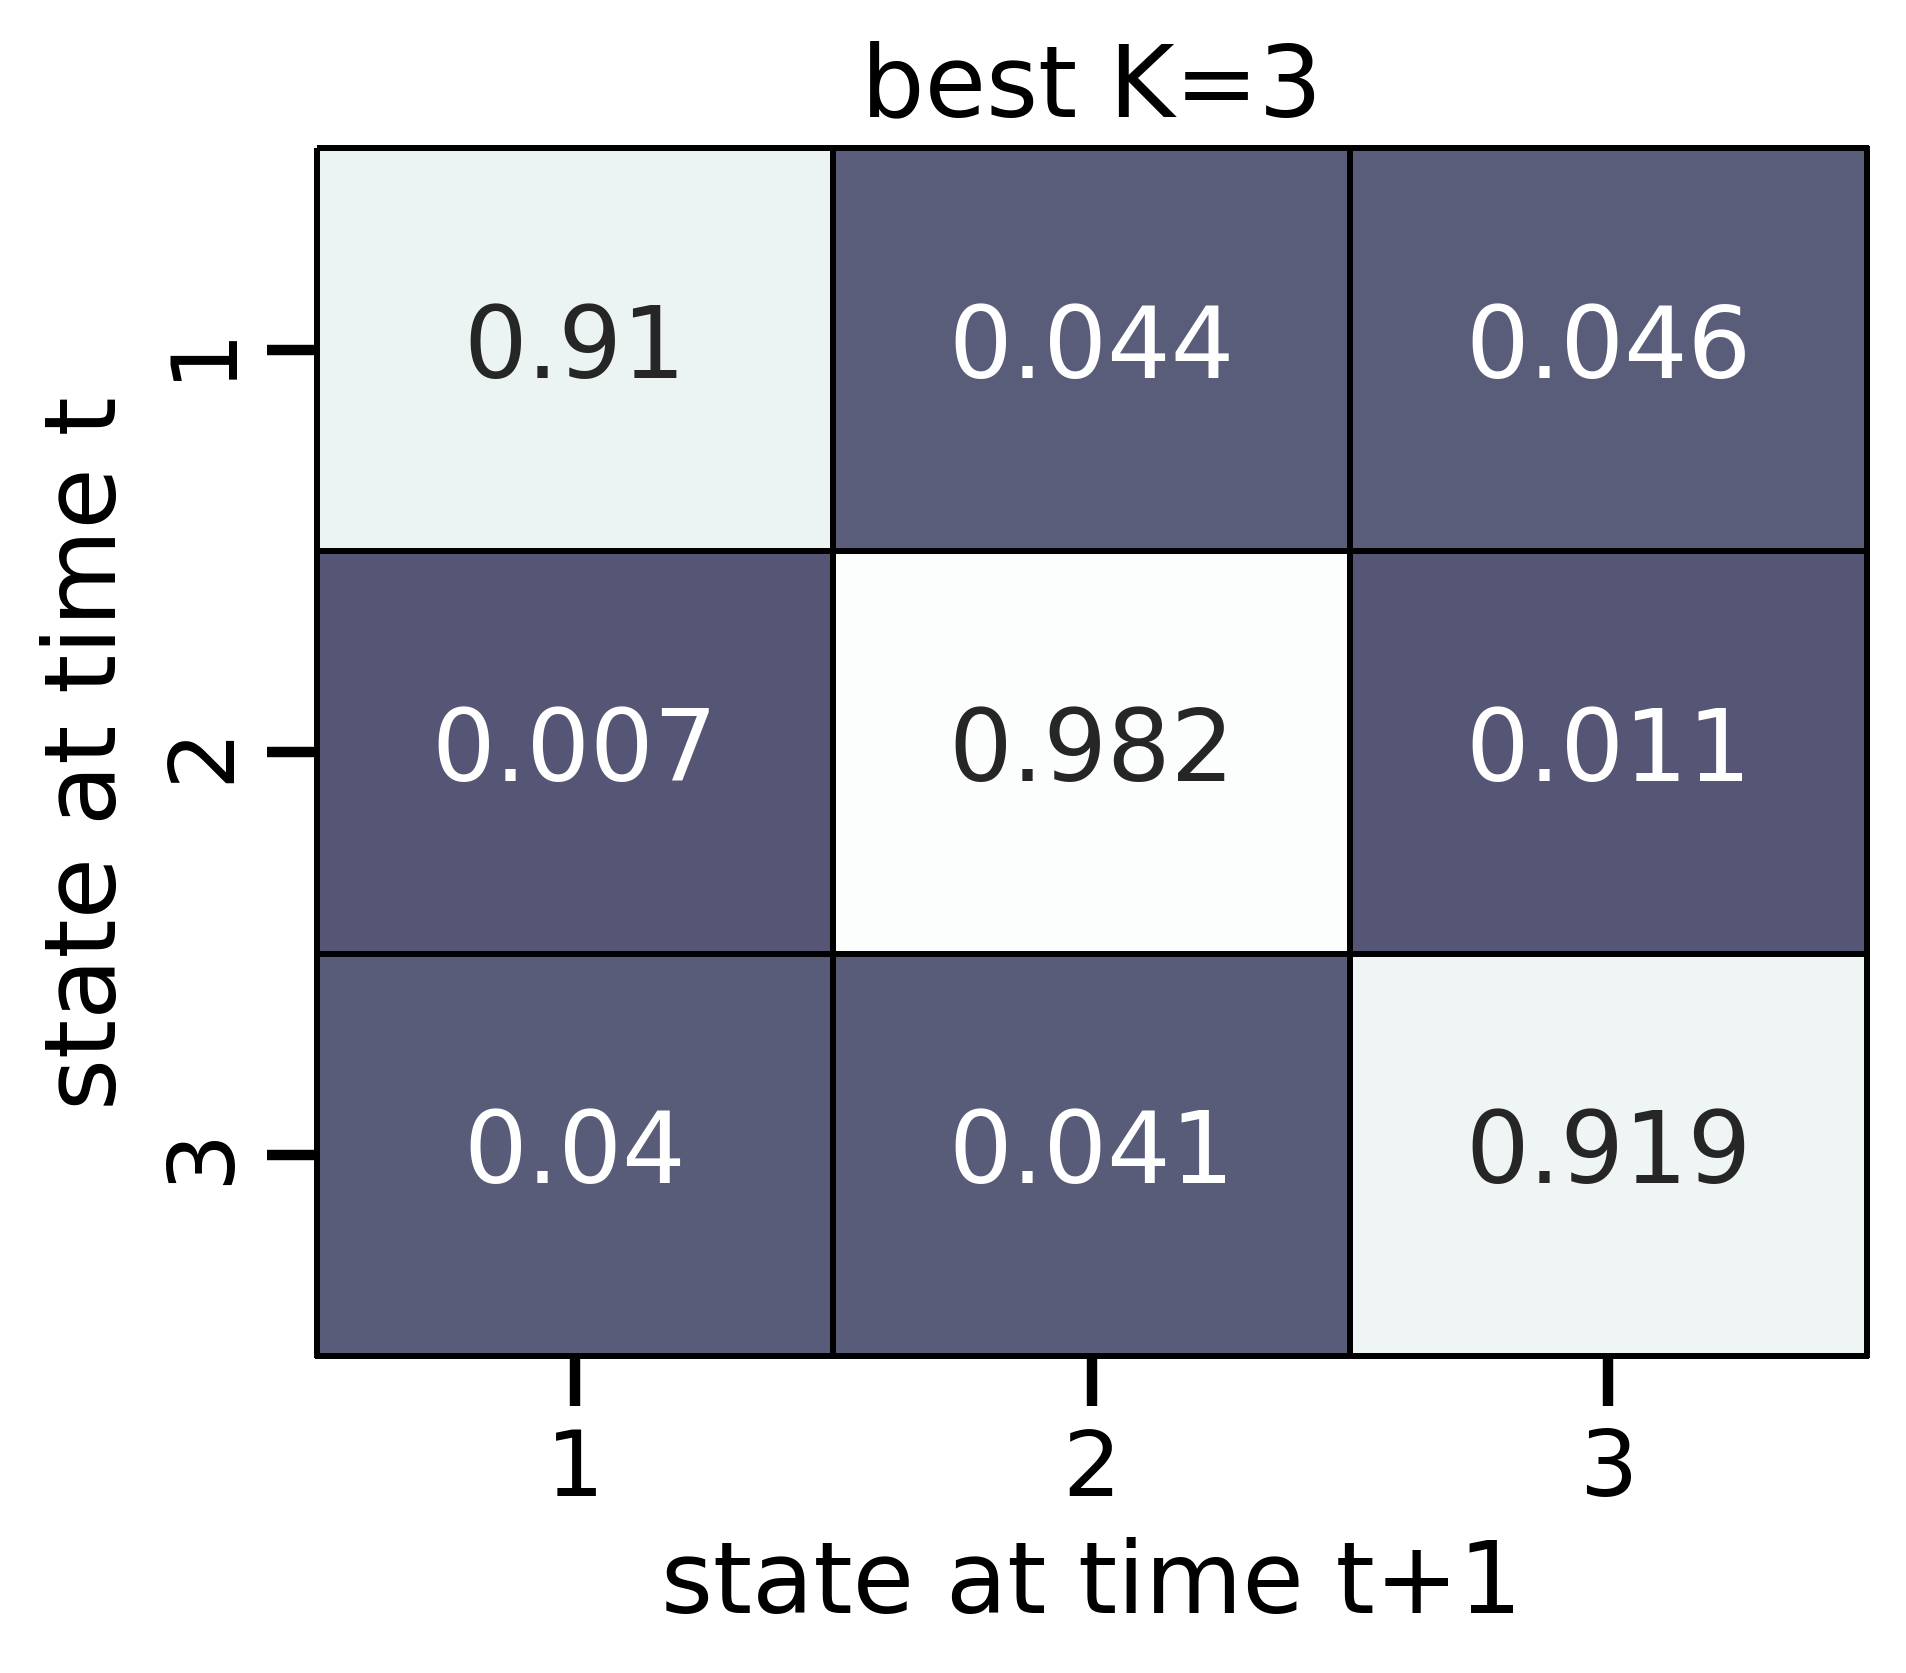

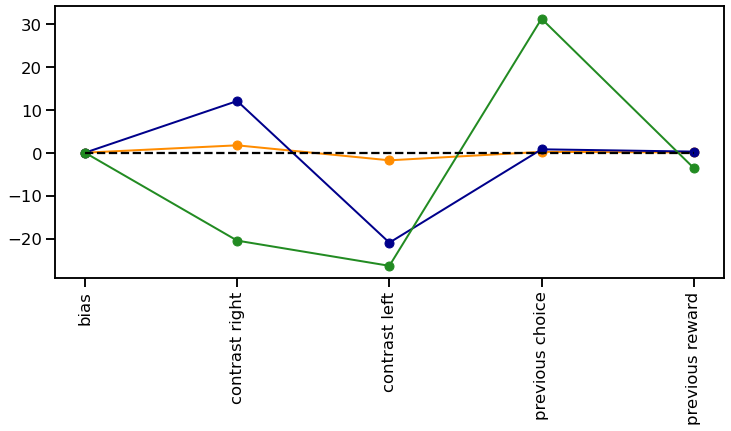

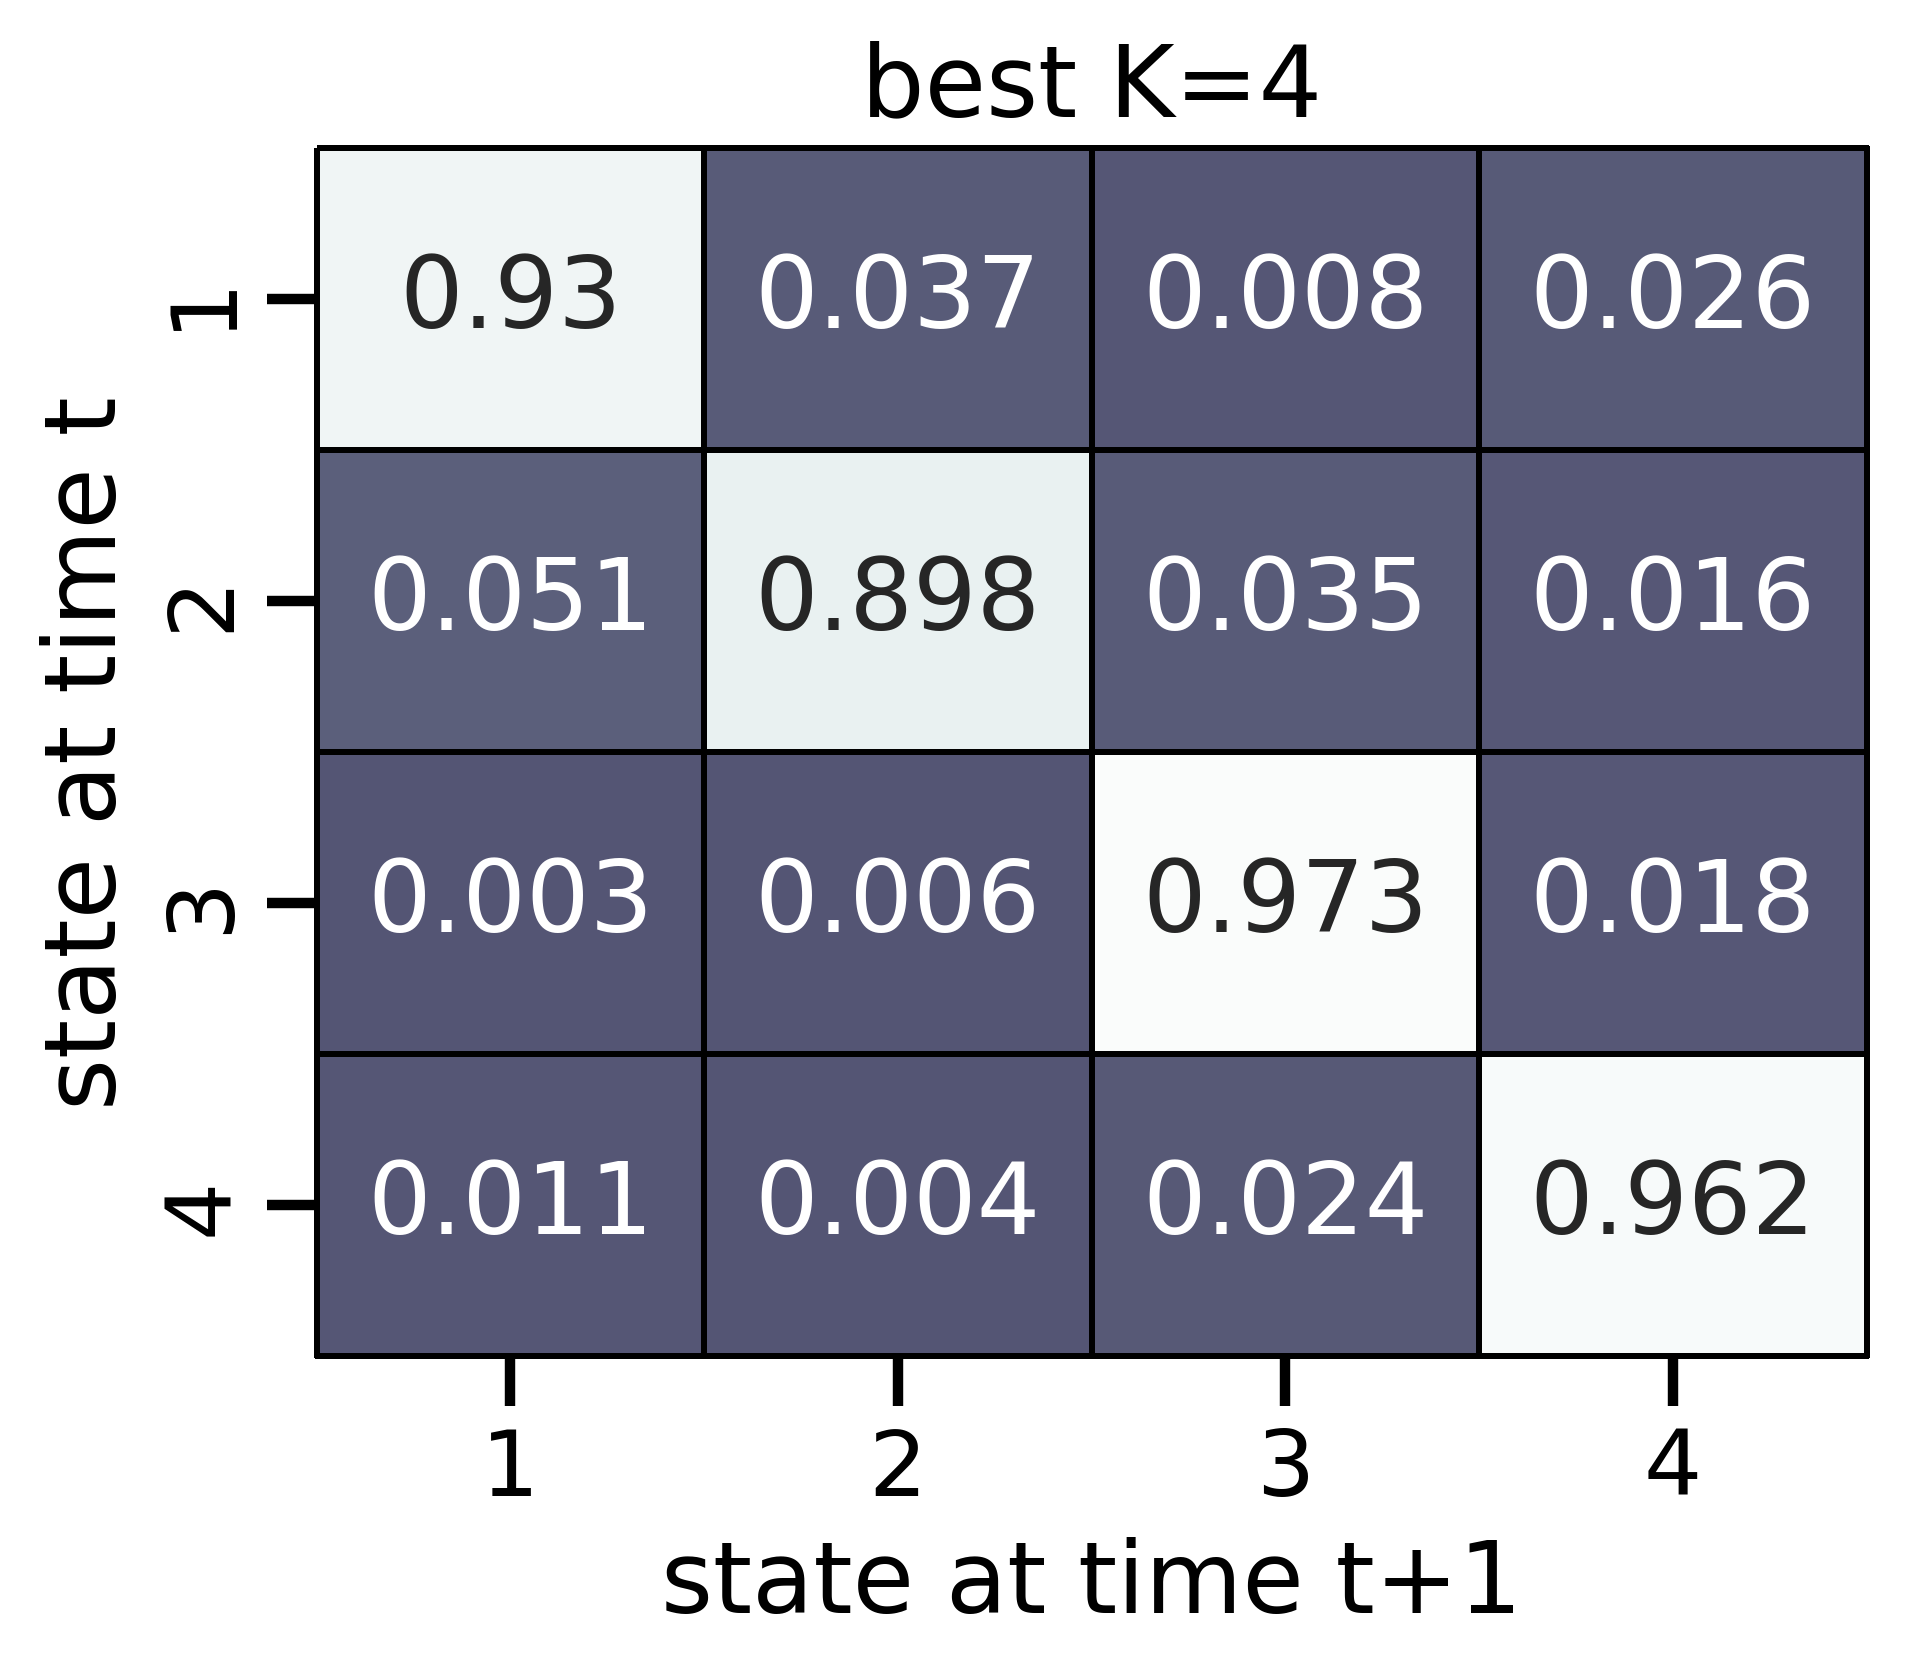

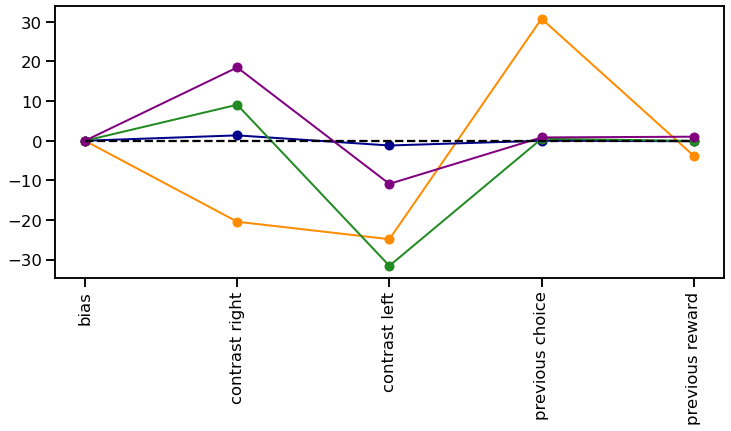

In [6]:
signedStimulus = False
D = 4
C = 2
inits = 20
pTanh = None

ll_vs_K = []
for K in [1,2,3,4]: #[1,2,3]:#,2,3]:#,4,5]:
    df = pd.DataFrame(columns=['trainLl', 'trainAccuracy' ,'P', 'pi', 'W']) 
    for init in range(0,inits):
        data = np.load(f'../data_IBL/wittenAnimals_pTanh={pTanh}_standardGLMHMM_{K}-state_init={init}_signedStimulus={signedStimulus}.npz')
        df.loc[init, 'P'] = data['P']
        df.loc[init, 'pi'] = data['pi']
        df.loc[init, 'W'] = data['W']
        df.loc[init, 'trainLl'] = data['trainLl']

        # # plot parameters for each initialization
        # # plot_transition_matrix(df.loc[bestInd, 'P'][0], title=f'best K={K}')
        # fig, axes = plt.subplots(1, figsize=(12,5))
        # plot_constant_weights(df.loc[init, 'W'][0], axes, labels=myFeatures[signedStimulus], colors=colorsStates)
        # axes.set_ylim(-10,10)
        # axes.set_title(f'init {init}')

    # print(ll)
    ll = np.array(df['trainLl']).flatten()
    bestInd = np.argmax(ll)

    ll_vs_K.append(ll[bestInd])

    # plot final log-likelihood across init
    if K==3:
        fig, axes = plt.subplots(1, figsize=(12,5))
        axes.scatter(range(20), ll)
        axes.set_ylabel('train (total) log-like')
        axes.set_xlabel('init')
        axes.set_ylim(-0.365,-0.364)


    print(df.loc[bestInd, 'W'][0].shape)
    # reorder parameters if necessary

    # plot parameters
    plot_transition_matrix(df.loc[bestInd, 'P'][0], title=f'best K={K}')
    fig, axes = plt.subplots(1, figsize=(12,5))
    plot_constant_weights(df.loc[bestInd, 'W'][0], axes, labels=myFeatures[signedStimulus], colors=colorsStates)
    # axes.set_ylim(-2,9)

    # # saving best models
    # np.savez(f'../data_IBL/Best_standardGLMHMM_wittenAnimals_pTanh={pTanh}_signedStimulus={signedStimulus}_{K}-state', P=df.loc[bestInd, 'P'], pi=df.loc[bestInd, 'pi'], W=df.loc[bestInd, 'W'])
    

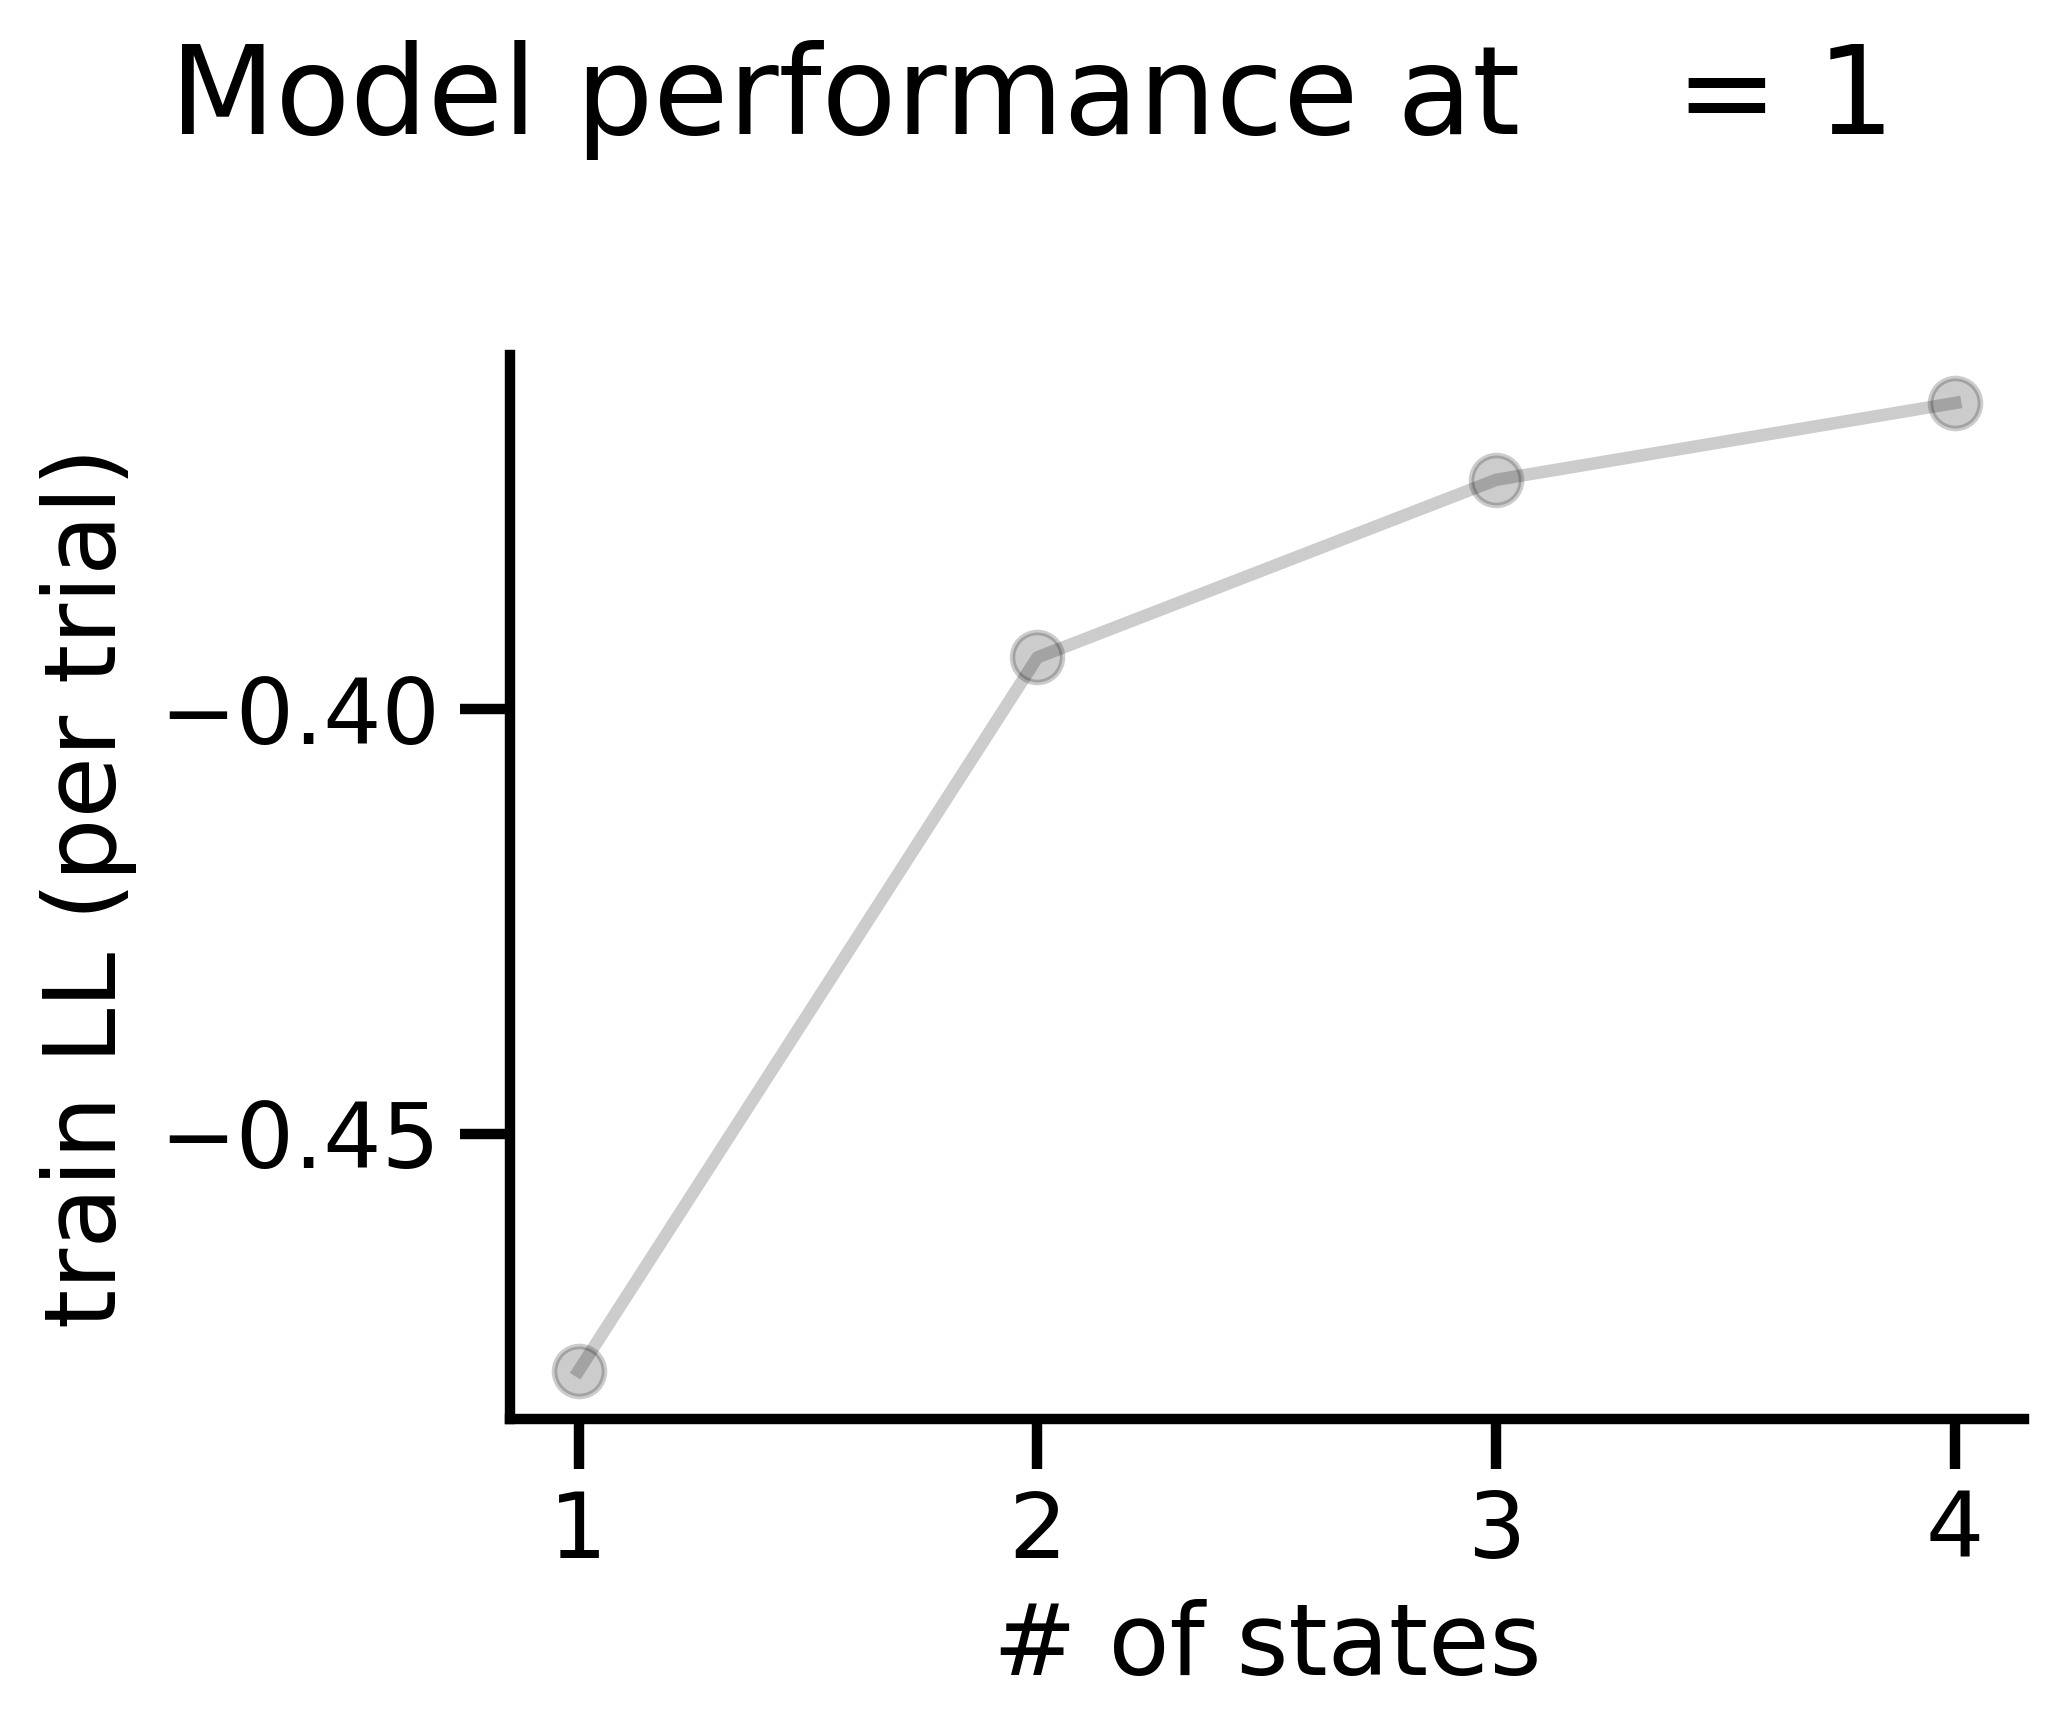

In [7]:
fig, axes = plt.subplots(1, figsize=(5.5,4.5), dpi=400)
axes.plot([1,2,3,4], ll_vs_K,'-o', color='black',alpha=0.2)
axes.set_xticks([1,2,3,4])
# axes.set_yticks([0,0.01,0.02,0.03],[0,0.01,0.02,0.03])
axes.set_xlabel('# of states')
axes.set_ylabel('train LL (per trial)')
axes.spines[['right', 'top']].set_visible(False)
fig.suptitle('Model performance at    = 1', size=22)
fig.tight_layout()

# GLM fits with different values of pTanh

Text(0.5, 1.0, 'GLM fits on global dataset with all animals')

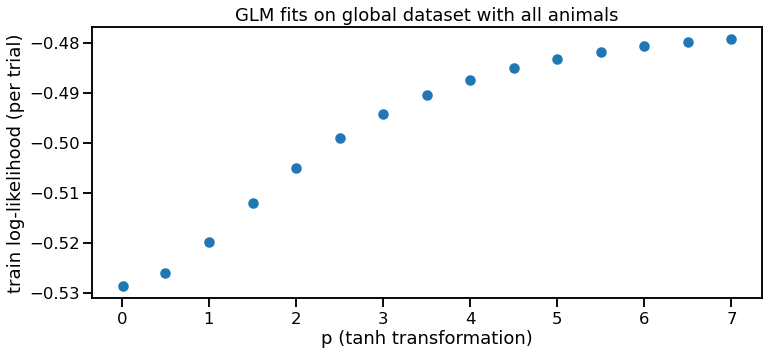

In [32]:
pTanhList = [0.01, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7]
signedStimulus = True

ll = []
for pTanh in pTanhList:
    data = np.load(f'../data_IBL/allAnimals_pTanh={pTanh}_GLM_signedStimulus={signedStimulus}.npz')
    ll.append(data['trainLl']) 

fig, axes = plt.subplots(1, figsize=(12,5))
axes.scatter(pTanhList, ll)
axes.set_ylabel('train log-likelihood (per trial)')
axes.set_xlabel('p (tanh transformation)')
axes.set_title('GLM fits on global dataset with all animals')
    

Text(0.5, 1.0, 'Inferred GLM weights for different values of p (tanh transformation)')

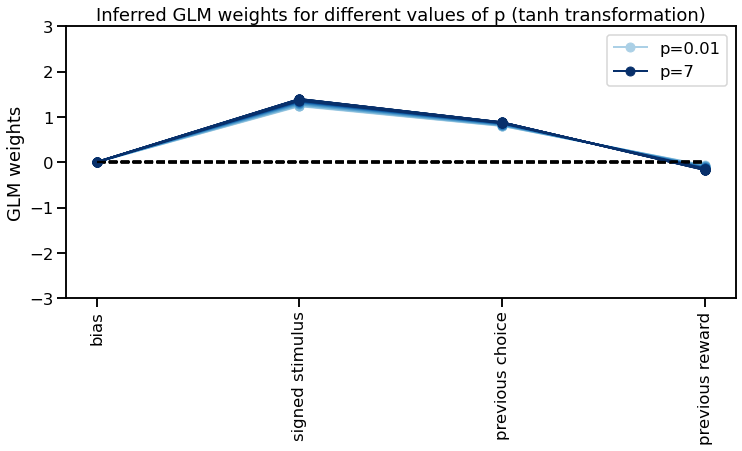

In [33]:
import matplotlib as mpl
n_lines = 10
x = np.linspace(0, 10, 100)
y = np.sin(x[:, None] + np.pi * np.linspace(0, 1, n_lines))
c = np.arange(1, n_lines + 1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmapBlue = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmapBlue.set_array([])
print(cmapBlue)

fig, axes = plt.subplots(1, figsize=(12,5))
axes.set_ylim(-3,3)
z = 0
labels=myFeatures[signedStimulus]
for pTanh in pTanhList:
    data = np.load(f'../data_IBL/allAnimals_pTanh={pTanh}_GLM_signedStimulus={signedStimulus}.npz')
    if pTanh in [0.01,7]:
        axes.plot(data['W'][0,0,:,1], marker='o', color=cmapBlue.to_rgba(z+4),label=f'p={pTanh}', linewidth=2)
    else:
        axes.plot(data['W'][0,0,:,1], marker='o', color=cmapBlue.to_rgba(z+4), linewidth=2)
        # plot_constant_weights(data['W'][0], axes, labels=myFeatures[signedStimulus], colors=[cmapBlue.to_rgba(z+1)])
    axes.plot(labels,np.zeros((len(labels),1)),'k--')
    axes.set_xticks(np.arange(0,len(labels)))
    axes.set_xticklabels(labels,rotation=90)
    z += 1
axes.legend()
axes.set_ylabel('GLM weights')
axes.set_title('Inferred GLM weights for different values of p (tanh transformation)')

# Standard GLM-HMM Global fits - 3 state

Train log-like for ptanh=0.01 and signed stimulus contrast = False is 
-0.4187
Train log-like for ptanh=5 and signed stimulus contrast = False is 
-0.4101
Train log-like for ptanh=0.01 and signed stimulus contrast = True is 
-0.4187
Train log-like for ptanh=5 and signed stimulus contrast = True is 
-0.4108


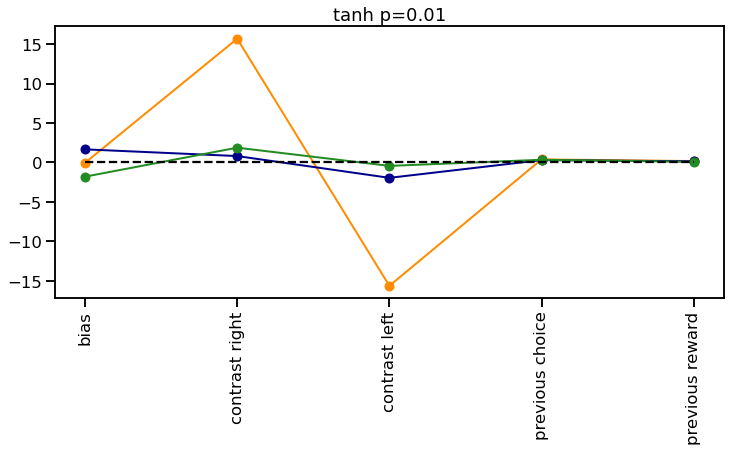

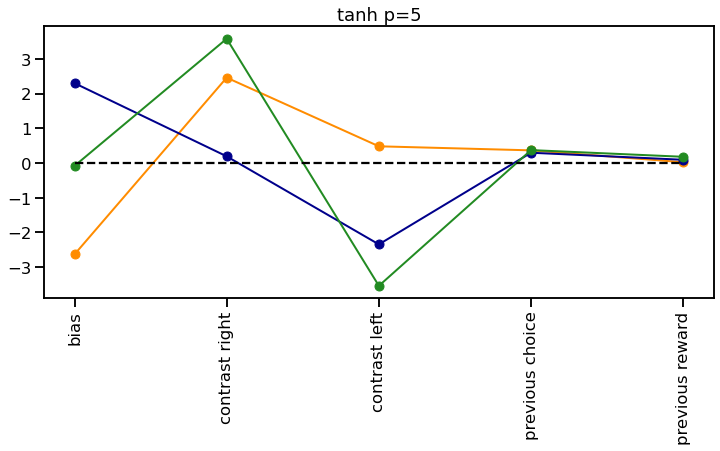

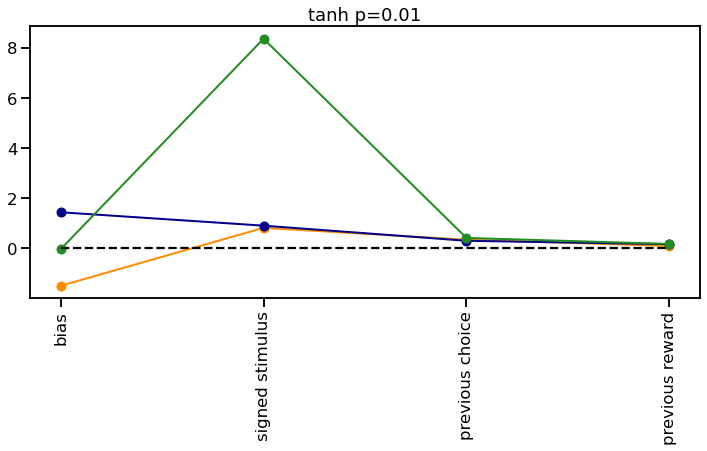

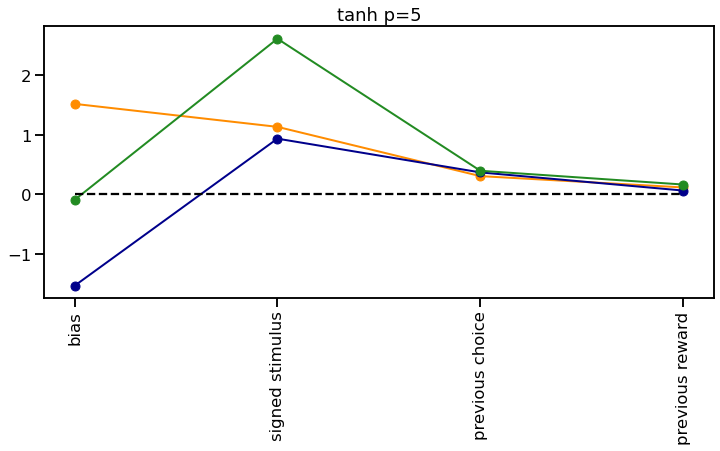

In [34]:
K = 3
inits = 25
D_signed = [5, 4]
Ll_total = np.zeros((2,2))
pTanhList = [0.01, 5]

reorder = [[2,0,1],[1,2,0], [0,1,2], [0,1,2]]
c = 0
for signedStimulus in [False, True]:
    for ind_pTanh in [0,1]:
        pTanh = pTanhList[ind_pTanh]

        Ll_temp = []
        for init in range(0, inits):
            data = np.load(f'../data_IBL/allAnimals_standardGLMHMM_{K}-state_pTanh={pTanh}_init={init}_signedStimulus={signedStimulus}.npz')
            Ll_temp.append(data['trainLl'])

        ind_best = np.argmax(Ll_temp)
        data_best = np.load(f'../data_IBL/allAnimals_standardGLMHMM_{K}-state_pTanh={pTanh}_init={ind_best}_signedStimulus={signedStimulus}.npz')
        Ll_total[ind_pTanh, signedStimulus] = data_best['trainLl']
        print(f'Train log-like for ptanh={pTanh} and signed stimulus contrast = {signedStimulus} is ')
        print(np.round(data_best['trainLl'], 4))

        fig, axes = plt.subplots(1, figsize=(12,5))
        plot_constant_weights(data_best["W"][0, reorder[c]], axes, labels=myFeatures[signedStimulus], colors=colorsStates)
        axes.set_title(f'tanh p={pTanh}')

        c+= 1

# fig, axes = plt.subplots(1, figsize=(12,5))
# for ind_pTanh in [0,1]:
#     pTanh = pTanhList[ind_pTanh]
#     axes.hist([0,1], Ll_total[ind_pTanh])
# plt.show()
        
        




